# **PRÁCTICA TEORÍA DE LA INFORMACIÓN**

In [1]:
#from google.colab import drive
#drive.mount("Datos")

# 0. Importamos las librerías necesarias.

In [2]:
import numpy as np
import scipy.signal as sgn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from skimage.util import view_as_windows

# 1. Leemos los datos

Para leer estas estructuras, haremos uso de la librería Pandas. Los dataframes que obtendremos serán los correspondientes a los estados de control (c), inyección de gaba (g) y recuperación (r) de diferentes neuronas. Además, en cada dataframe habrá información correspondiente a dos neuronas. Una conocida como LP (Lateral Pyloric neuron) y otra conocida como VD (Ventricular Dilator neuron), ambas correspondientes al sistema nervioso estomatogástrico. 

Los dataframes contendrán series temporales que analizaremos y representaremos para estudiar la información mutua y transferencia de entropía.

In [3]:
path_c = "DatosSinapsisArtificial/TrozoC/TrozoC.txt"
path_g = "DatosSinapsisArtificial/TrozoG/TrozoG.txt"
path_r = "DatosSinapsisArtificial/TrozoR/TrozoR.txt"

In [4]:
def read_data(path):
  df = pd.read_csv(path, delimiter="\t", names=["LP", "VD"], header=2, index_col=False, decimal=",")
  return df

In [5]:
df_c = read_data(path_c)
df_g = read_data(path_g)
df_r = read_data(path_r)

In [6]:
df_c

LP        VD
0         0.004883  0.015259
1         0.001526  0.024109
2        -0.010681  0.031128
3        -0.022278  0.041809
4        -0.028076  0.045471
...            ...       ...
19847695 -0.005798  0.017395
19847696 -0.007019  0.024109
19847697 -0.000916  0.029602
19847698  0.007324  0.039368
19847699  0.004272  0.049438

[19847700 rows x 2 columns]

Una vez tenemos la estructura dataframe de pandas para ambas neuronas, debemos decidir un umbral a partir del cual supondremos un potencial suficientemente alto para decidir que la información corresponde a un spike. Por ello, calcularemos la media y la desviación estándar de los potenciales de cada neurona. Como sabemos, en una distribución normal, el 99,7% de los datos estarán contenidos dentro de una banda de anchura máxima de tres desviaciones típicas. En este caso, como no tenemos una distribución normal no podemos suponer esto. Es por ello que utilizaremos una desviación máxima de hasta 4 veces la desviación típica para suponer que todos los datos excepto los spikes están en esa banda. Hacemos esto porque sabemos que existe un ruido que nos contamina la información del cual nos tenemos que deshacer, y sabemos que la amplitud de los spikes es bastante grande, así que no perderemos mucha información con esta configuración. 

In [7]:
def hallar_umbral(df):
  return (df.mean() + 4*df.std())

In [8]:
umbral_c = hallar_umbral(df_c)
umbral_g = hallar_umbral(df_g)
umbral_r = hallar_umbral(df_r)

Una vez hemos decidido que valor tendrá este umbral, trataremos de discretizar el dataframe de manera que tengamos únicamente el valor 1 para los instantes donde se ha superado el valor (que correspondería al spike), y el valor 0 para el resto de instantes.

In [9]:
def df_con_indices_mayores_al_umbral(df, umbral):
  return (df>umbral).astype(int)

In [10]:
trozoC_t = df_con_indices_mayores_al_umbral(df_c, umbral_c)
trozoG_t = df_con_indices_mayores_al_umbral(df_g, umbral_g)
trozoR_t = df_con_indices_mayores_al_umbral(df_r, umbral_r)

Una vez hemos conseguido esto, representaremos los potenciales de ambas neuronas para ver los spikes. Debido a que tenemos una cantidad muy grande de datos y si representamos todos (además de que el tiempo que tardará el programa será largo) no se verán lo suficientemente bien, representaremos únicamente entre ciertos valores que determinaremos nosotros.

In [11]:
def plot_original_signal_and_transformed_signal(df, df_t, umbral, nombre):
  fig, axs = plt.subplots(1, 2, figsize =(16, 6))
  fig.suptitle('{0}'.format(nombre), fontsize=20)

  for j in range(2):
    axs[j].set_title(list(df)[j])
    axs[j].plot(df.iloc[:,j], label="Señal original", color = "blue", lw=0.3)
    axs[j].plot(df_t.iloc[:,j], label="Señal transformada", color = "red", lw=0.3)

    xmin, xmax = axs[j].get_xlim()
    axs[j].plot([xmin, xmax], 2*[umbral[j]], label="Umbral", color = "green")
    axs[j].legend()

In [12]:
a = 0
b = 10000

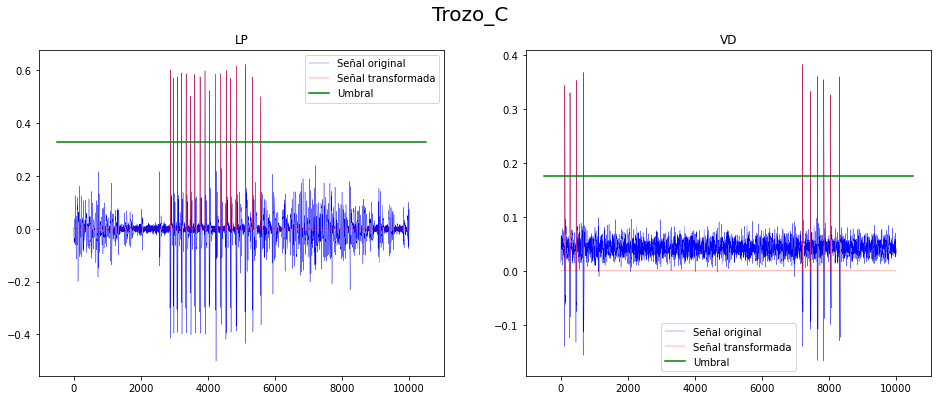

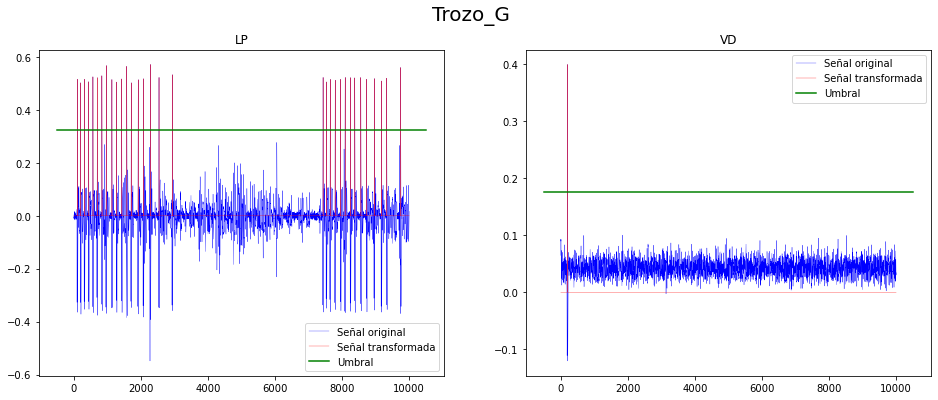

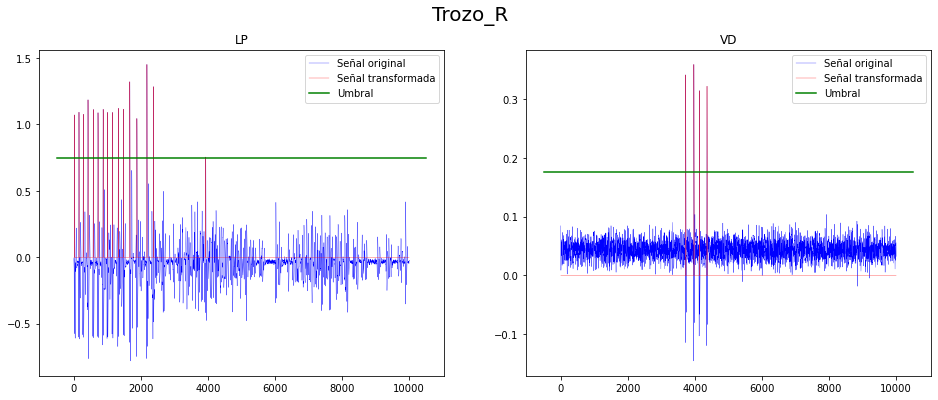

In [13]:
plot_original_signal_and_transformed_signal(df_c[a:b], trozoC_t[a:b]*df_c[a:b], umbral_c, "Trozo_C")
plot_original_signal_and_transformed_signal(df_g[a:b], trozoG_t[a:b]*df_g[a:b], umbral_g, "Trozo_G")
plot_original_signal_and_transformed_signal(df_r[a:b], trozoR_t[a:b]*df_r[a:b], umbral_r, "Trozo_R")

Como se puede ver, se han hecho dos representaciones del estado de las neuronas para distintos instantes, donde se han representado los umbrales que se han definido previamente, la señal original y la señal tras la transformación de unos y ceros.

En estas gráficas se han representado las primeras 10000 muestras de ambas neuronas para los 3 experimentos. Se pueden observar fácilmente los picos de las neuronas LP y de VD, así como las hiperpolarizaciones después de los máximos. 

En vista de estas gráficas, se puede ver que la elección del umbral no parece mala, ya que descarta los máximos correspondientes al ruido y recoge perfectamente los máximos correspondientes a los spikes. 

Una vez hemos visto estas gráficas, debemos darnos cuenta de lo siguiente: pese a que existan muchos instantes donde se sobrepasa el umbral de potencial que se ha definido, únicamente uno corresponderá al spike. Por ello, haremos uso de la función find_peaks de python para hallar el valor máximo dentro de la secuencia de unos que aparecerá en nuestro dataframe una vez lo hemos discretizado. Así, consideraremos que el spike corresponde únicamente al valor máximo de esta secuencia.

________________ TrozoC ________________
Total events (LP): 31683
Total events (VD): 22377
________________ TrozoG ________________
Total events (LP): 27274
Total events (VD): 15663
________________ TrozoR ________________
Total events (LP): 25433
Total events (VD): 18704


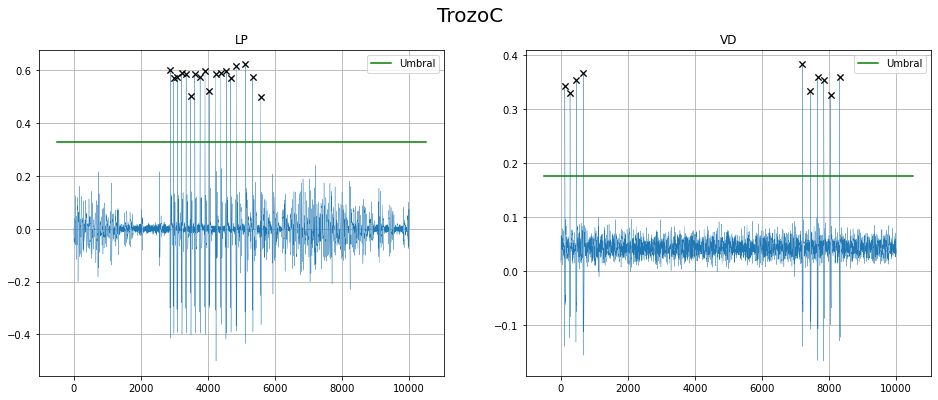

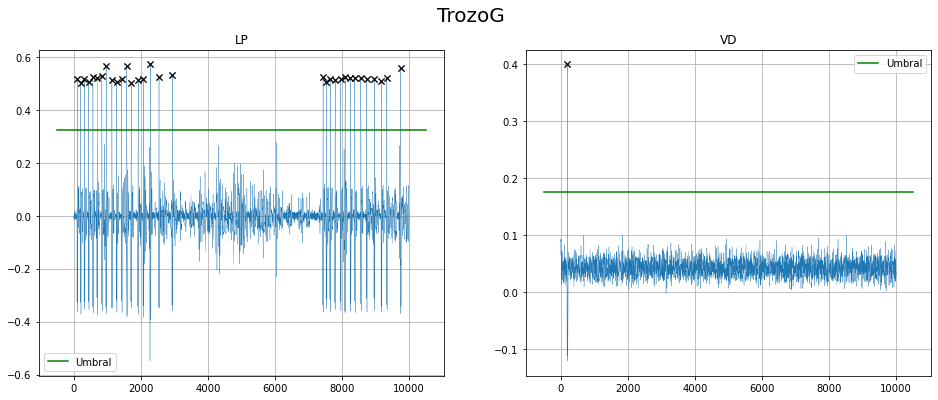

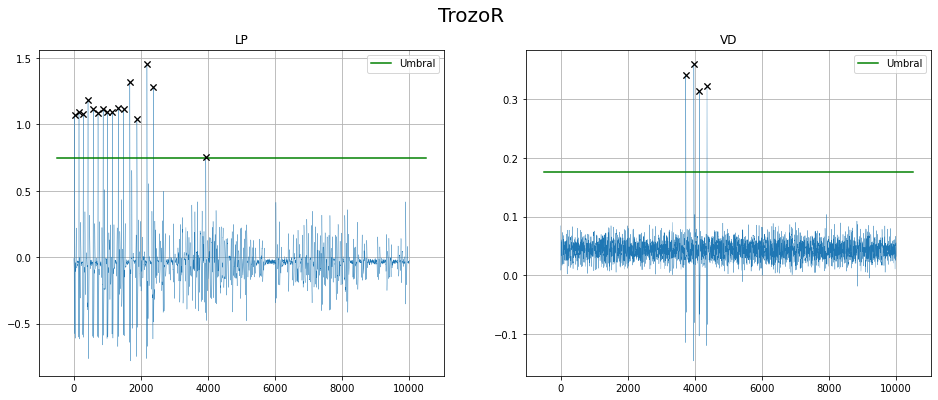

In [14]:
def hallar_picos(df, nombre, umbral, distancia=1, n=10000):
  print("________________ {0} ________________".format(nombre))
  lp_events, _ = sgn.find_peaks(df.LP[:n], umbral[0], distance = distancia)
  vd_events, _ = sgn.find_peaks(df.VD[:n], umbral[1], distance = distancia)
    
  t_lp,_ = sgn.find_peaks(df.LP, umbral[0],distance = distancia)
  t_vd,_ = sgn.find_peaks(df.VD, umbral[1],distance = distancia)
  print("Total events (LP): {0}".format(len(t_lp)))
  print("Total events (VD): {0}".format(len(t_vd)))

  fig, axs = plt.subplots(1, 2, figsize =(16, 6))
  fig.suptitle('{0}'.format(nombre), fontsize=20)

  for j in range(2):
    axs[j].set_title(list(df)[j])
    axs[j].plot(df.iloc[0:10000,j], lw=0.3)
    axs[j].grid(True)

    xmin, xmax = axs[j].get_xlim()
    axs[j].plot([xmin, xmax], 2*[umbral[j]], label="Umbral", color = "green")
    axs[j].legend()

    axs[0].plot(lp_events, df.iloc[:,0][lp_events], "x", color="black")
    axs[1].plot(vd_events, df.iloc[:,1][vd_events], "x", color="black")

  return t_lp, t_vd


lp_spikes_C, vd_spikes_C = hallar_picos(df_c, 'TrozoC', umbral_c)
lp_spikes_G, vd_spikes_G = hallar_picos(df_g, 'TrozoG', umbral_g)
lp_spikes_R, vd_spikes_R = hallar_picos(df_r, 'TrozoR', umbral_r)


Esto a continuación podemos borrarlo.

________________ TrozoC ________________
Total events (LP): 31683
Total events (VD): 22377
________________ TrozoG ________________
Total events (LP): 27274
Total events (VD): 15663
________________ TrozoR ________________
Total events (LP): 25433
Total events (VD): 18704


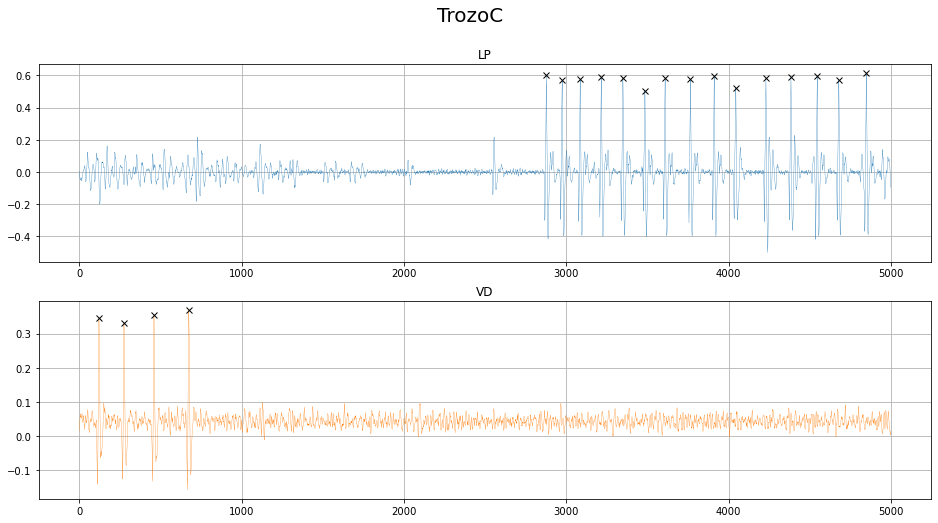

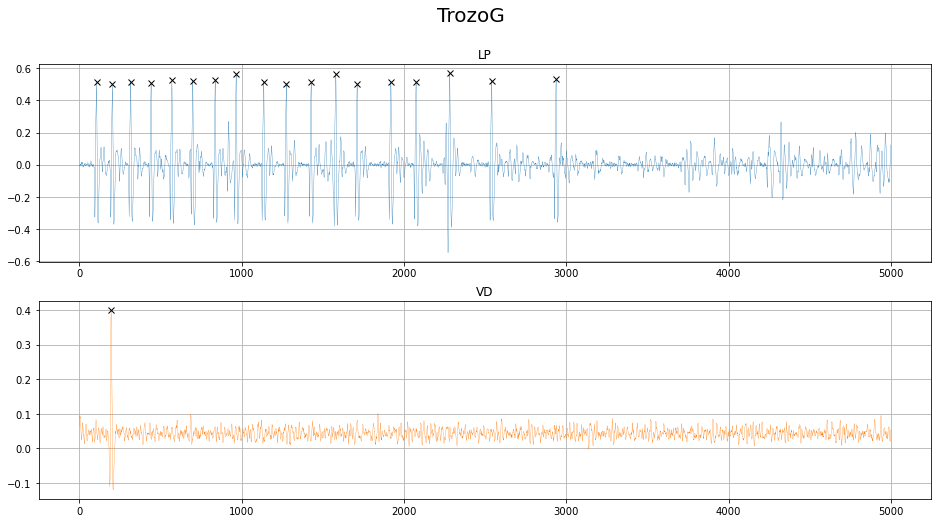

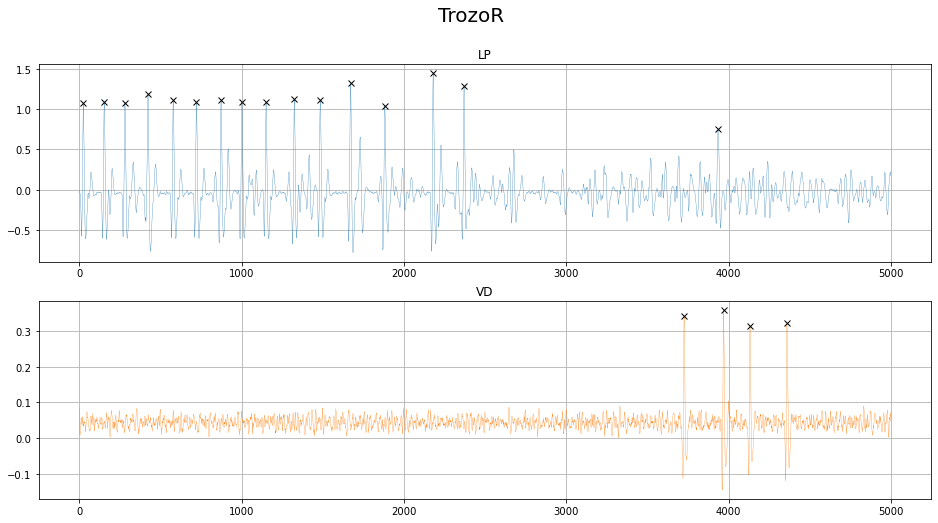

In [15]:
def hallar_picos(df, nombre, umbral, distancia=1, n=5000):
  print("________________ {0} ________________".format(nombre))
  lp_events, _ = sgn.find_peaks(df.LP[:n], umbral[0], distance = distancia)
  vd_events, _ = sgn.find_peaks(df.VD[:n], umbral[1], distance = distancia)
    
  t_lp,_ = sgn.find_peaks(df.LP, umbral[0],distance = distancia)
  t_vd,_ = sgn.find_peaks(df.VD, umbral[1],distance = distancia)
  print("Total events (LP): {0}".format(len(t_lp)))
  print("Total events (VD): {0}".format(len(t_vd)))
    
  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.set_size_inches(16, 8)
  fig.suptitle('{0}'.format(nombre), fontsize=20)

  ax1.plot(df.LP[:n], lw=0.3)
  ax1.plot(lp_events, df.LP[:n][lp_events], "x", color="black")
  ax1.set_title("LP")
  ax1.grid(True)

  ax2.plot(df.VD[:n],'tab:orange', lw=0.3)
  ax2.plot(vd_events, df.VD[:n][vd_events], "x", color="black")
  ax2.set_title("VD")
  ax2.grid(True)
    
  return t_lp, t_vd

lp_spikes_C, vd_spikes_C = hallar_picos(df_c, 'TrozoC', umbral_c)
lp_spikes_G, vd_spikes_G = hallar_picos(df_g, 'TrozoG', umbral_g)
lp_spikes_R, vd_spikes_R = hallar_picos(df_r, 'TrozoR', umbral_r)

Con esta discretización que hemos hecho, tenemos en ambas neuronas para los tres casos que aproximadamente el 0.1% de los casos corresponden a spikes.

A continuación, estudiaremos cual es el espacio temporal entre spikes. Hacemos esto porque puede darse que exista un número determinado de spikes demasiado cercano y sea debido al ruido. Para ello, podemos mostrar las estadísticas correspondientes a las distancias mínimas y máximas entre spikes, la media y la mediana.

________________ TrozoC ________________
________ LP ________
Min: 3
Max: 20759
Mean: 626.2851145761
Medium: 154.0
________ VD ________
Min: 4
Max: 29910
Mean: 886.7108509116911
Medium: 160.0
________________ TrozoG ________________
________ LP ________
Min: 3
Max: 14121
Mean: 600.4518388149452
Medium: 155.0
________ VD ________
Min: 4
Max: 29910
Mean: 875.8066085654708
Medium: 159.0
________________ TrozoR ________________
________ LP ________
Min: 32
Max: 23023
Mean: 644.1548049701164
Medium: 155.0
________ VD ________
Min: 2
Max: 21409
Mean: 1045.7619716511301
Medium: 191.0


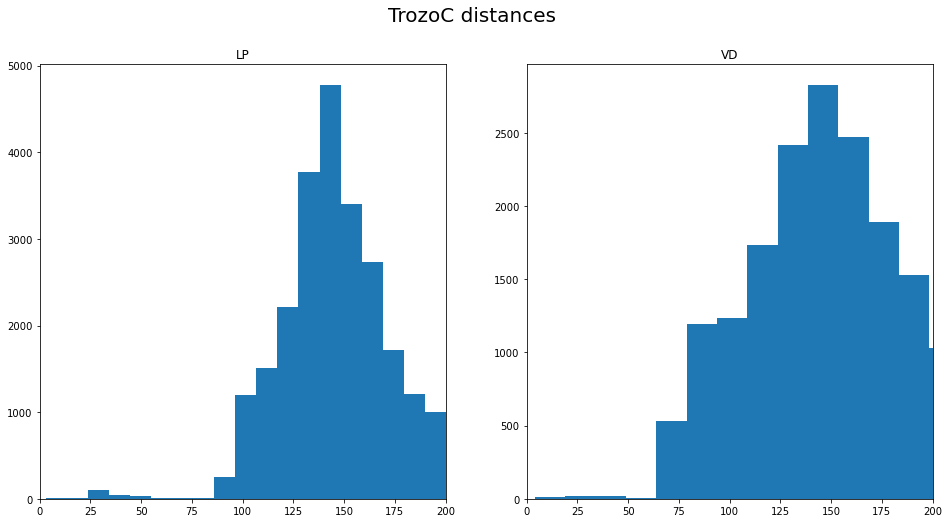

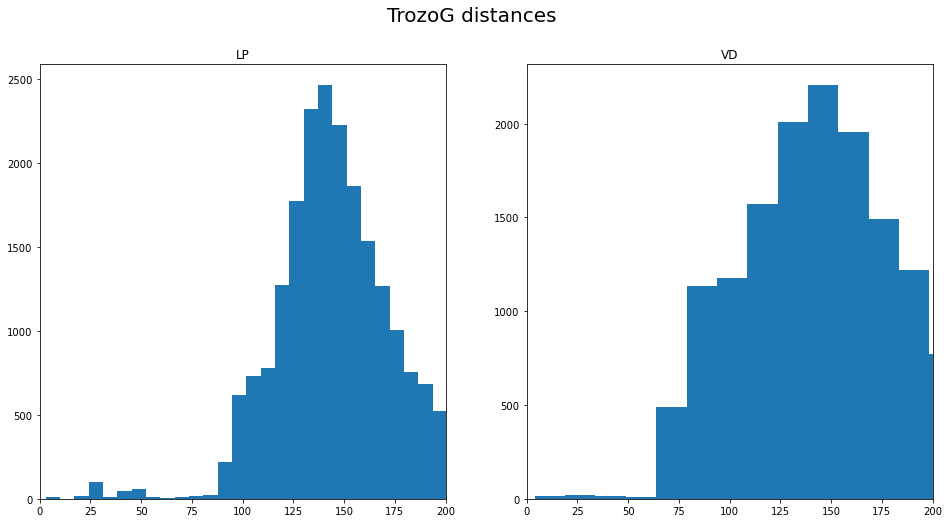

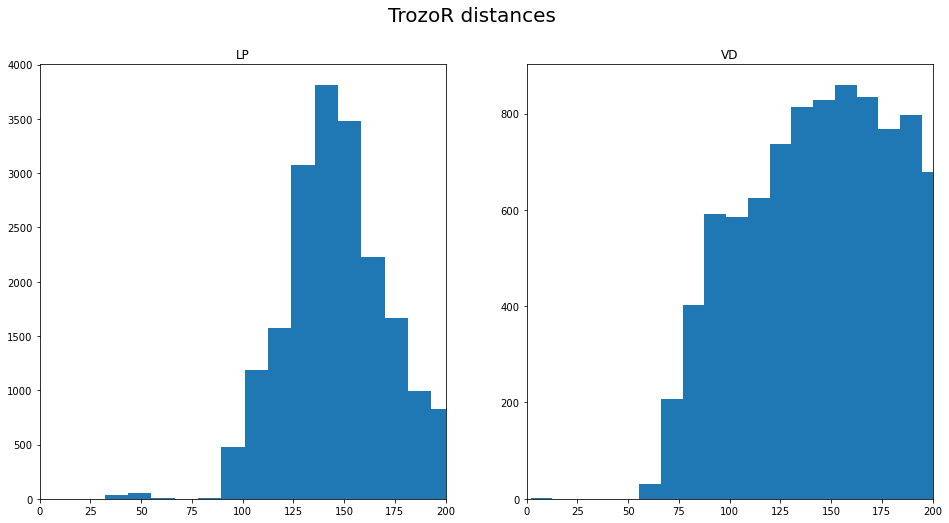

In [16]:
def stats_spikes(df, señal_lp, señal_vd, lmin, lmax):
  distancias_lp = np.diff(señal_lp)
  distancias_vd = np.diff(señal_vd)

  print("________________ {0} ________________".format(df))
  print("________ LP ________")
  print('Min: {0}'.format(np.amin(distancias_lp)))
  print('Max: {0}'.format(np.amax(distancias_lp)))
  print('Mean: {0}'.format(np.mean(distancias_lp)))
  print('Medium: {0}'.format(np.median(distancias_lp)))
  print("________ VD ________")
  print('Min: {0}'.format(np.amin(distancias_vd)))
  print('Max: {0}'.format(np.amax(distancias_vd)))
  print('Mean: {0}'.format(np.mean(distancias_vd)))
  print('Medium: {0}'.format(np.median(distancias_vd)))
    
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(16, 8)
  fig.suptitle('{0} distances'.format(df), fontsize=20)

  ax1.hist(distancias_lp, bins=2000)
  ax1.set_xlim((lmin, lmax))
  ax1.set_title("LP")

  ax2.hist(distancias_vd, bins=2000)
  ax2.set_title("VD")
  ax2.set_xlim((lmin, lmax))

stats_spikes('TrozoC', lp_spikes_C, vd_spikes_C, 0, 200)
stats_spikes('TrozoG', lp_spikes_G, vd_spikes_R, 0, 200)
stats_spikes('TrozoR', lp_spikes_R, vd_spikes_G, 0, 200)

Como podemos ver, la distancia mínima obtenida entre los spikes es de 2 unidades temporales, correspondiente a la neurona VD de la fase R. Por otro lado, la distancia máxima obtenida es 32, correspnodiente a la neurona LP de la fase R. Como podemos ver en el histograma, podemos ver que es muy poco común que las distancias entre spikes sean parecidas a dos unidades temporales; así que el histograma nos indica que esto puede darse debido al ruido. De hecho, se puede observar como las distancias entre spikes menores a 60 unidades son muy poco frecuentes, por lo que podría considerarse que todas estas son debidas al ruido. 

Por ello, haremos un experimento donde, en lugar de hacer uso de las muestras de las señales cada 0.1 ms (que es lo que nos dan los datos), haremos estos espacios más grandes, y estudiaremos cual será la distancia mínima entre spikes para estas discretizaciones.

In [17]:
distancias = [1,2,3,4,5,6,7,8,9,10,11,12]
for distancia in distancias:
    c_lp = np.amin(np.diff(sgn.find_peaks(df_c["LP"], umbral_c[0], distance = distancia)[0]))
    c_vd = np.amin(np.diff(sgn.find_peaks(df_c["VD"], umbral_c[1], distance = distancia)[0]))

    g_lp = np.amin(np.diff(sgn.find_peaks(df_g["LP"], umbral_g[0], distance = distancia)[0]))
    g_vd = np.amin(np.diff(sgn.find_peaks(df_g["VD"], umbral_g[1], distance = distancia)[0]))

    r_lp = np.amin(np.diff(sgn.find_peaks(df_r["LP"], umbral_r[0], distance = distancia)[0]))
    r_vd = np.amin(np.diff(sgn.find_peaks(df_r["VD"], umbral_r[1], distance = distancia)[0]))
    
    print(f'Min distance between spikes with distance forced to {distancia} = {min(c_lp,c_vd,g_lp,g_vd,r_lp,r_vd)}')

Min distance between spikes with distance forced to 1 = 2
Min distance between spikes with distance forced to 2 = 2
Min distance between spikes with distance forced to 3 = 3
Min distance between spikes with distance forced to 4 = 4
Min distance between spikes with distance forced to 5 = 5
Min distance between spikes with distance forced to 6 = 6
Min distance between spikes with distance forced to 7 = 8
Min distance between spikes with distance forced to 8 = 8
Min distance between spikes with distance forced to 9 = 9
Min distance between spikes with distance forced to 10 = 10
Min distance between spikes with distance forced to 11 = 14
Min distance between spikes with distance forced to 12 = 14


Cuando forzamos una distancia entre spikes de entre 6 y 8 unidades, la distancia mínima entre spikes es de 8 unidades, lo que garantiza realizar un análisis de transmisión de información de neuronas usando hasta 8 bits. Es por ello que para maximizar el tamaño de la ventana, usaremos mínimo una distancia de 8 unidades para detectar los spikes. 

Si calculamos el número de spikes por neurona para cada etapa para medidas de 8 bits:

________________ TrozoC ________________
Total events (LP): 31674
Total events (VD): 22373
________________ TrozoG ________________
Total events (LP): 27262
Total events (VD): 15662
________________ TrozoR ________________
Total events (LP): 25433
Total events (VD): 18700


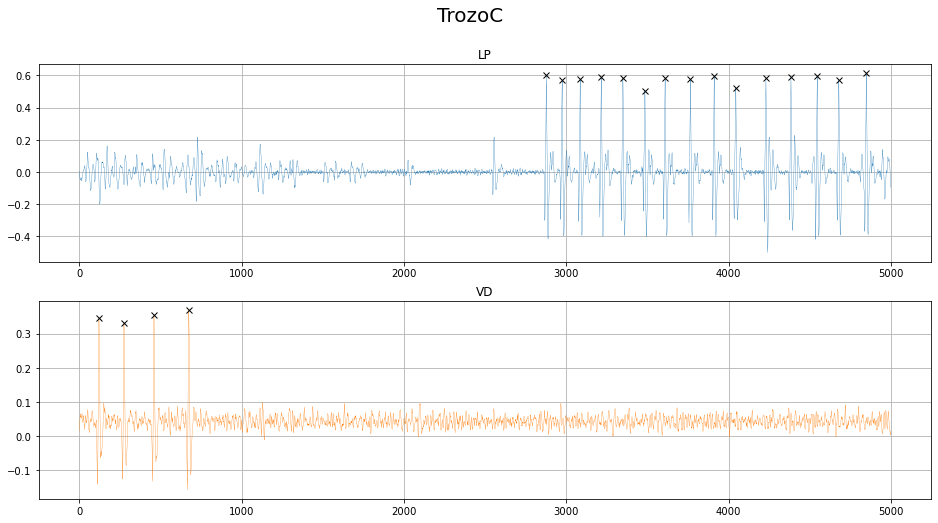

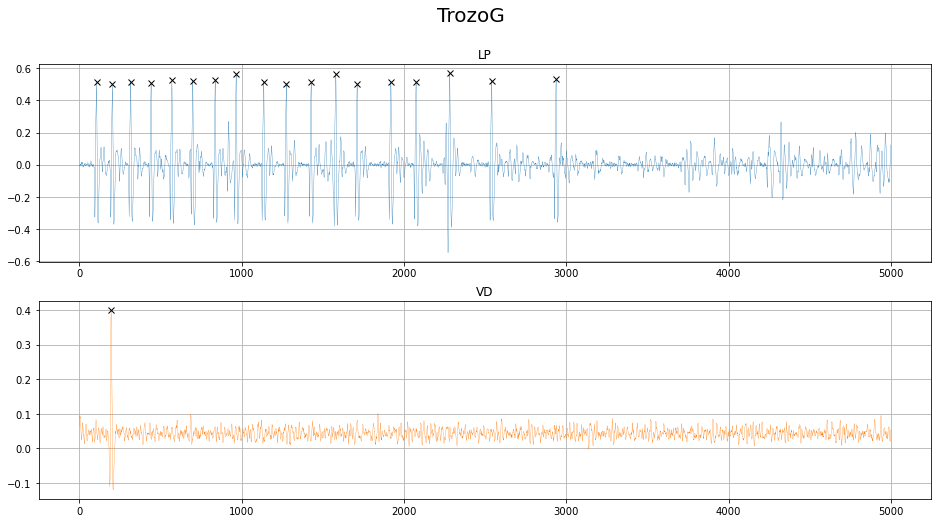

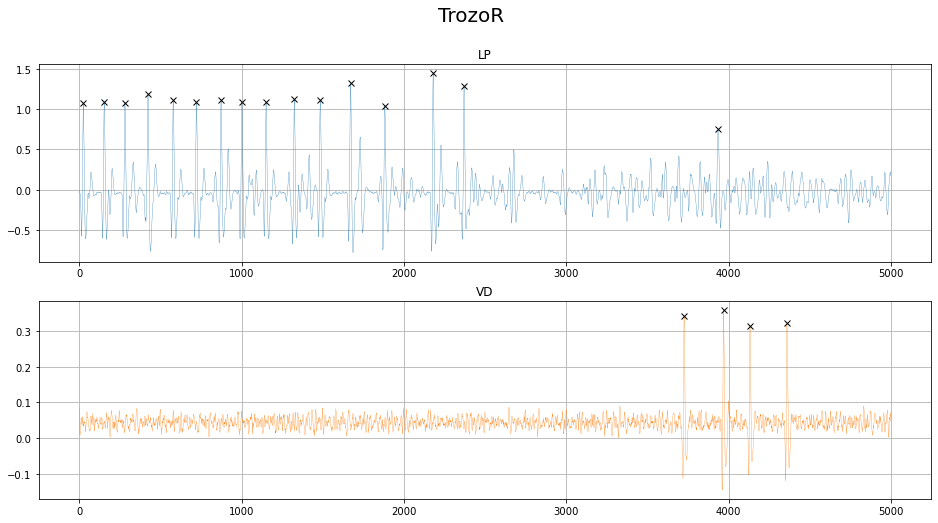

In [18]:
lp_spikes_C, vd_spikes_C = hallar_picos(df_c, 'TrozoC', umbral_c, distancia = 8)
lp_spikes_G, vd_spikes_G = hallar_picos(df_g, 'TrozoG', umbral_g, distancia = 8)
lp_spikes_R, vd_spikes_R = hallar_picos(df_r, 'TrozoR', umbral_r, distancia = 8)

________________ TrozoC ________________
________ LP ________
Min: 14
Max: 20759
Mean: 626.4630758058914
Medium: 154.0
________ VD ________
Min: 8
Max: 29910
Mean: 886.8693903093152
Medium: 160.0
________________ TrozoG ________________
________ LP ________
Min: 19
Max: 14121
Mean: 600.716151278383
Medium: 155.0
________ VD ________
Min: 8
Max: 29910
Mean: 875.9939568960907
Medium: 159.0
________________ TrozoR ________________
________ LP ________
Min: 32
Max: 23023
Mean: 644.1548049701164
Medium: 155.0
________ VD ________
Min: 60
Max: 21409
Mean: 1045.8287465679075
Medium: 191.0


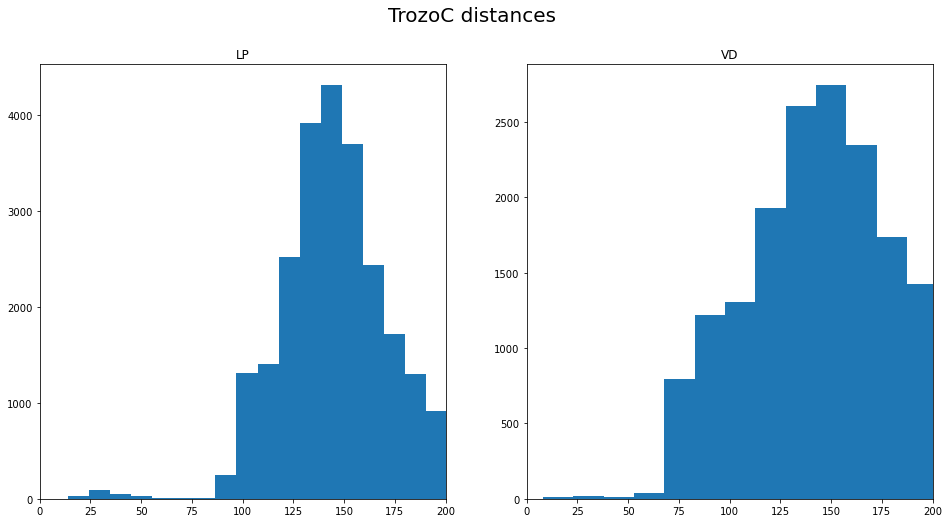

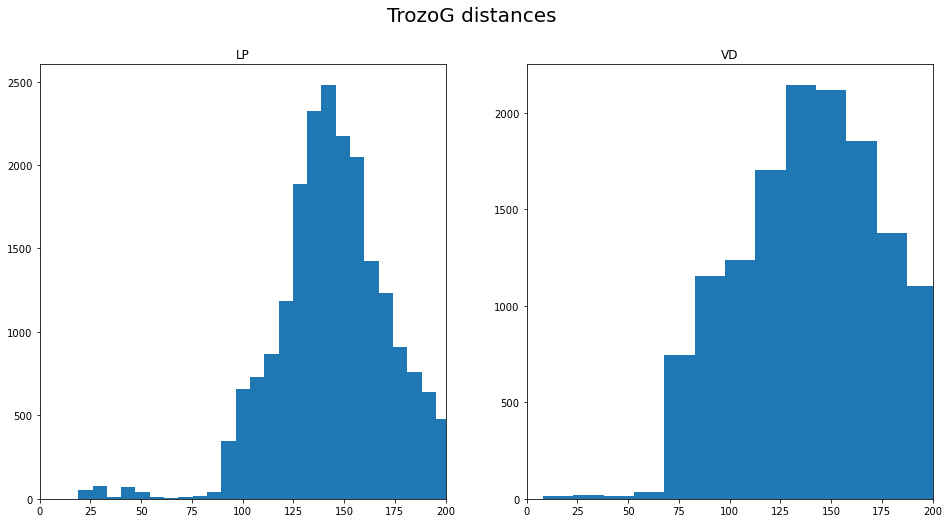

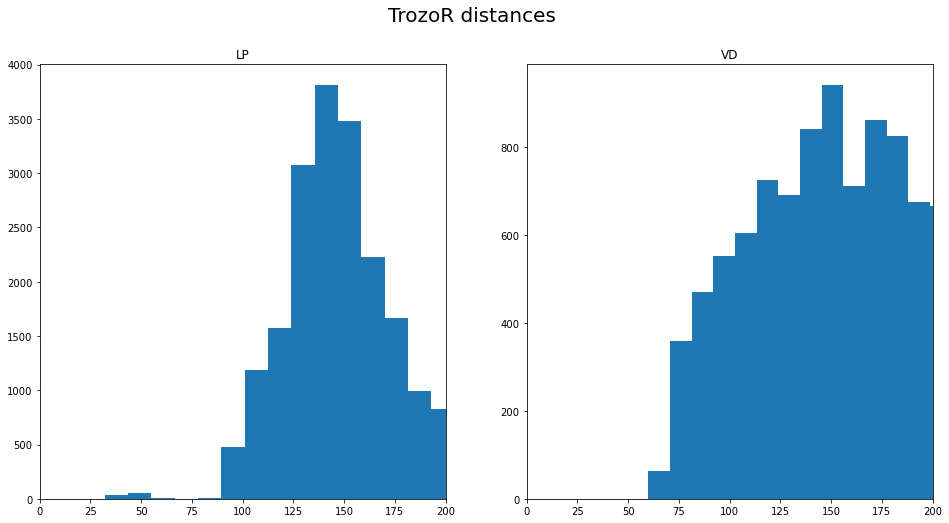

In [19]:
stats_spikes('TrozoC', lp_spikes_C, vd_spikes_C, 0, 200)
stats_spikes('TrozoG', lp_spikes_G, vd_spikes_R, 0, 200)
stats_spikes('TrozoR', lp_spikes_R, vd_spikes_G, 0, 200)

# Discretización de señales

Ahora, discretizaremos las señales asociando el valor 1 al momento donde tenemos spike y el valor 0 donde no tenemos spike.

In [20]:
def codificacion_señal(df, lp_spikes, vd_spikes):
  df["LP_picos"] = 0
  df.loc[lp_spikes, "LP_picos"] = 1
  df["VD_picos"] = 0
  df.loc[vd_spikes, "VD_picos"] = 1

def plot_señales_discretizadas(df, nombre, n):
  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.set_size_inches(16, 8)
  plt.suptitle('Discretize {0}'.format(nombre), fontsize=20)
  ax1.plot(df["LP_picos"].iloc[:n],lw=0.6)
  ax1.set_title("LP", fontsize=16)
  ax2.plot(df["VD_picos"].iloc[:n],'tab:red',lw=0.6)
  ax2.set_title("VD", fontsize=16)

In [21]:
df_c

LP        VD
0         0.004883  0.015259
1         0.001526  0.024109
2        -0.010681  0.031128
3        -0.022278  0.041809
4        -0.028076  0.045471
...            ...       ...
19847695 -0.005798  0.017395
19847696 -0.007019  0.024109
19847697 -0.000916  0.029602
19847698  0.007324  0.039368
19847699  0.004272  0.049438

[19847700 rows x 2 columns]

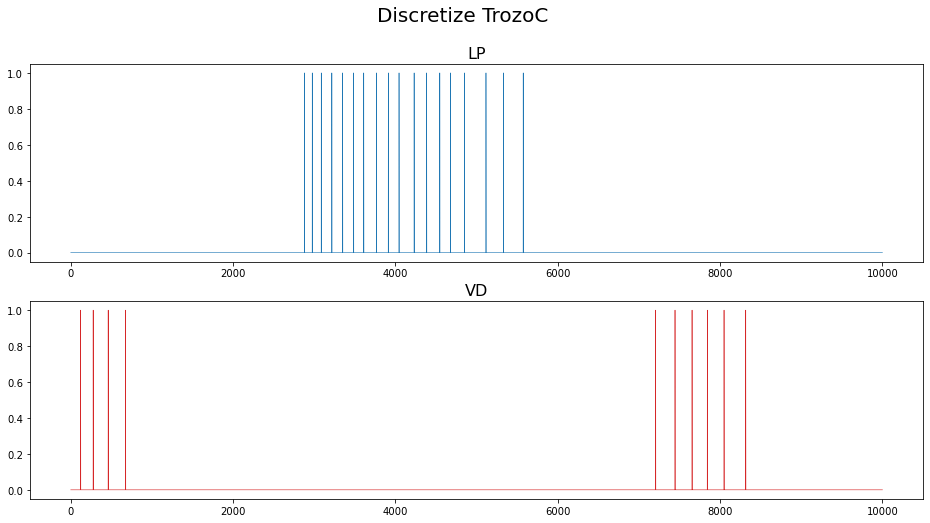

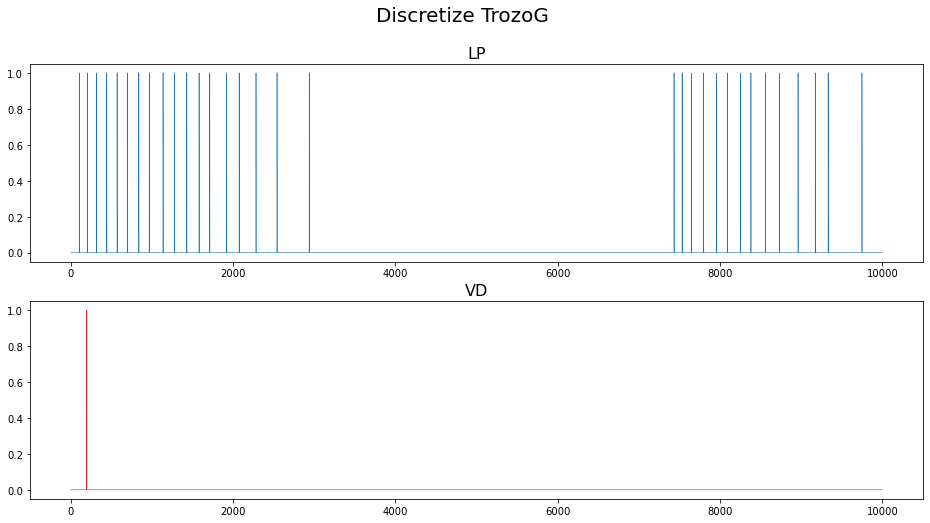

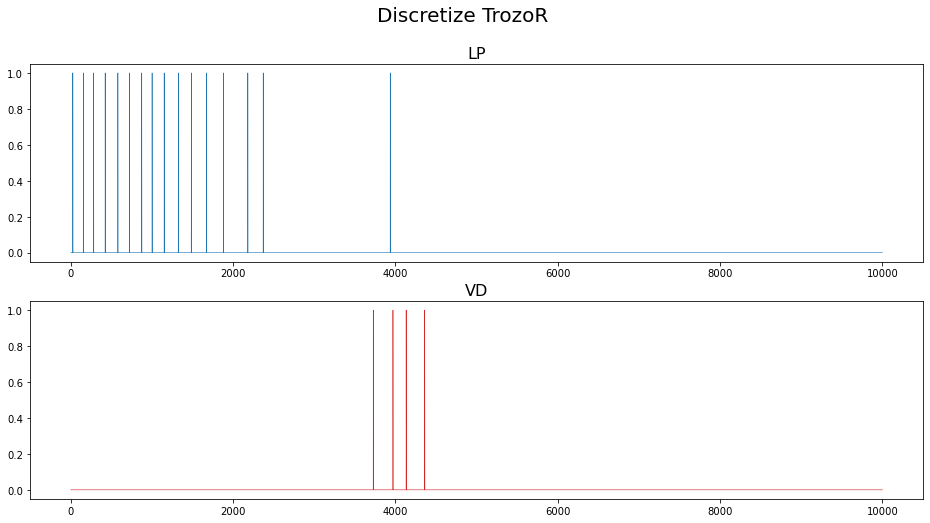

In [22]:
trozoC = codificacion_señal(df_c, lp_spikes_C, vd_spikes_C)
plot_señales_discretizadas(df_c, 'TrozoC', 10000)

trozoG = codificacion_señal(df_g, lp_spikes_G, vd_spikes_G)
plot_señales_discretizadas(df_g, 'TrozoG', 10000)

trozoR = codificacion_señal(df_r, lp_spikes_R, vd_spikes_R)
plot_señales_discretizadas(df_r, 'TrozoR', 10000)

# Cálculo de entropía e informacióm mutua

La información mutua (MI) es una cantidad que mide la dependencia estadística entre dos variables. En este caso, calcularemos la información mutua para hallar la dependencia estadística entre los spikes de las neuronas. Para ello, mediremos la MI a partir de dos ecuaciones que describiremos a continuación para diferentes tamaños de ventana.

Una manera de medir la información mutua es a través de las entropias de las variables:
\begin{equation}
MI(X,Y) = \sum_{x}\sum_y p(x,y) log_{2}{\frac{p(x,y)}{p(x)p(y)}}
\end{equation}

De esta manera, podemos calcular la información mutua a partir de las probabilidades (o frecuencias) de hallar spikes para cada una de las dos neuronas.

Otra manera es calcular la MI a partir de las entropías:
\begin{equation}
MI(X,Y) = S(X) + S(Y) - S(X|Y)
\end{equation}
Donde las entropías se calculan como:
\begin{equation}
S(X) = - \sum_x p(x) log_{2}(p(x))
\end{equation}


La medida de información puede normalizarse dividiendo la información mutua entre la entropía asociada a cada neurona, dando lugar a la entropía normalizada. De esta manera, se puede medir la transferencia de información del estímulo de una neurona a otra:
\begin{equation}
IT_{x \rightarrow y} = \frac{MI(X,Y)}{S(Y)} \hspace{3 cm} IT_{y \rightarrow x} = \frac{MI(X,Y)}{S(X)}
\end{equation}

Donde, la primera corresponde a la transmisión de información de la neurona "x" a la neurona "y", y la segunda de la neurona "y" a la neurona "x".

En primer lugar, calcularemos la información mutua a partir de las entropías.

In [23]:
def pasar_a_palabras(signal, n_bits, n):
  if n_bits == 1:
    return np.array(list(map(str, signal)))
  else:
    signal_bin = view_as_windows(np.array(signal), window_shape=n_bits, step=n)
    return np.array([''.join(map(str,bins)) for bins in signal_bin])

def calcular_prob(x):
  keys, counts = np.unique(x, return_counts=True)
  return dict(zip(keys, counts/len(x)))

def prob_conjunta(x,y):
  xy = list(map('|'.join,zip(x, y)))
  keys, counts = np.unique(xy, return_counts=True)
  return dict(zip(keys,counts/len(x)))

def calcular_entropia(x):
  return - np.sum([w * np.log2(w) for w in x.values()])

def calcular_MI(x,y):
  px, py, pxy = calcular_prob(x), calcular_prob(y), prob_conjunta(x,y)
  ex, ey = calcular_entropia(px), calcular_entropia(py)
  mi = 0
  for element in pxy:
    kx, ky = element.split("|")
    mi += pxy[element] * np.log2(pxy[element]/(px[kx]*py[ky]))
  return mi, ex, ey

In [24]:
lp_words = pasar_a_palabras(df_c['LP_picos'], 2, 2)
vd_words = pasar_a_palabras(df_c['VD_picos'], 2, 2)

In [25]:
def calcular_probabilidades(df, codificacion, n_bits, nombre):
  print("________________ {0} ________________".format(nombre))
  lp_words = pasar_a_palabras(df[f'LP_{codificacion}'], n_bits, n_bits)
  vd_words = pasar_a_palabras(df[f'VD_{codificacion}'], n_bits, n_bits)
  prob_lp,prob_vd = calcular_prob(lp_words),calcular_prob(vd_words)
  joint_prob_lpvd = prob_conjunta(lp_words,vd_words)
  mi, e_clp, e_cvd = calcular_MI(lp_words, vd_words)
  print(mi, e_clp, e_cvd)
  print("Probabilidades LP con {0} bit: \n{1}".format(n_bits, json.dumps(prob_lp,sort_keys=True, indent=2)))
  print("\nProbabilidades VD con {0} bit: \n{1}".format(n_bits, json.dumps(prob_vd,sort_keys=True, indent=2)))
  print("\nProbabilidades Conjuntas LP y VD con {0} bit: \n{1}".format(n_bits, json.dumps(joint_prob_lpvd,sort_keys=True, indent=2)))
  print("\nEntropía LP con {0} bit: {1}".format(n_bits, e_clp))
  print("\nEntropía VD con {0} bit: {1}".format(n_bits, e_cvd))
  print("\nInformación Mutua LP y VD con {0} bit: {1}".format(n_bits, mi))

In [26]:
calcular_probabilidades(df_c, codificacion="picos", n_bits = 2, nombre="Trozo C")

________________ Trozo C ________________
8.350617692183611e-06 0.034252882700666114 0.025326836464494976
Probabilidades LP con 2 bit: 
{
  "00": 0.9968082951677021,
  "01": 0.0015932324652226707,
  "10": 0.0015984723670752782
}

Probabilidades VD con 2 bit: 
{
  "00": 0.9977455322279156,
  "01": 0.0011263773636239968,
  "10": 0.001128090408460426
}

Probabilidades Conjuntas LP y VD con 2 bit: 
{
  "00|00": 0.9945542304649909,
  "00|01": 0.0011260750615940385,
  "00|10": 0.0011279896411171067,
  "01|00": 0.001593030930536032,
  "01|01": 1.0076734331937706e-07,
  "01|10": 1.0076734331937706e-07,
  "10|00": 0.0015982708323886395,
  "10|01": 2.0153468663875412e-07
}

Entropía LP con 2 bit: 0.034252882700666114

Entropía VD con 2 bit: 0.025326836464494976

Información Mutua LP y VD con 2 bit: 8.350617692183611e-06


Una vez hemos definido esta función, nos encargaremos de definir una función que divida las señales de cada etapa para distintos tamaños de ventana, dando lugar a distintas codificaciones. 

In [27]:
def compute_signal_by_bins(bin_size, df, coding):
  lp_bins, vd_bins = {}, {}
  for nbin in bin_size:
    lp_bins[nbin] = view_as_windows(np.array(df[f"LP_{coding}"]), window_shape=nbin, step=nbin).sum(axis=1)
    vd_bins[nbin] = view_as_windows(np.array(df[f"VD_{coding}"]), window_shape=nbin, step=nbin).sum(axis=1)
  return lp_bins, vd_bins

def compute_information(word_size, bin_size, lp_bins, vd_bins, fix):
  information = {}
  for nbits in word_size:
    mi_l, elp_l, evd_l = [], [], []
    for nbins in bin_size:
      if fix == True:
        lp_words = pasar_a_palabras(lp_bins[nbins], nbits, nbits)
        vd_words = pasar_a_palabras(vd_bins[nbins], nbits, nbits)
      else:
        lp_words = pasar_a_palabras(lp_bins[nbins], nbits, 1)
        vd_words = pasar_a_palabras(vd_bins[nbins], nbits, 1)
      mi, e_lp, e_vd = calcular_MI(lp_words, vd_words)
      mi_l.append(mi)
      elp_l.append(e_lp)
      evd_l.append(e_vd)
    information[nbits] = {"mi":np.array(mi_l), "elp": np.array(elp_l), "evd": np.array(evd_l), 'ti_lp_vd':np.array(mi_l)/np.array(elp_l), 'ti_vd_lp':np.array(mi_l)/np.array(evd_l)}
  return information


In [28]:
def pasar_a_palabras(signal, n_bits, n):
  if n_bits == 1:
    return np.array(list(map(str, signal)))
  else:
    signal_bin = view_as_windows(np.array(signal), window_shape=n_bits, step=n)
    return np.array([''.join(map(str,bins)) for bins in signal_bin])

In [29]:
bin_size = range(1,151, 10)
lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, df = df_c, coding = 'picos')
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, df = df_g, coding = 'picos')
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, df = df_r, coding = 'picos')

In [30]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, True)

## Representamos la entropía, MI y TI usando palabras fijas.

En este caso, el tamaño de las palabras es fijo. Se realizarán los cálculos para un tamaño de palabra desde 1 bit hasta 8 bits, y un tamaño de ventana desde 1 unidad hasta 150. 

### Entropía

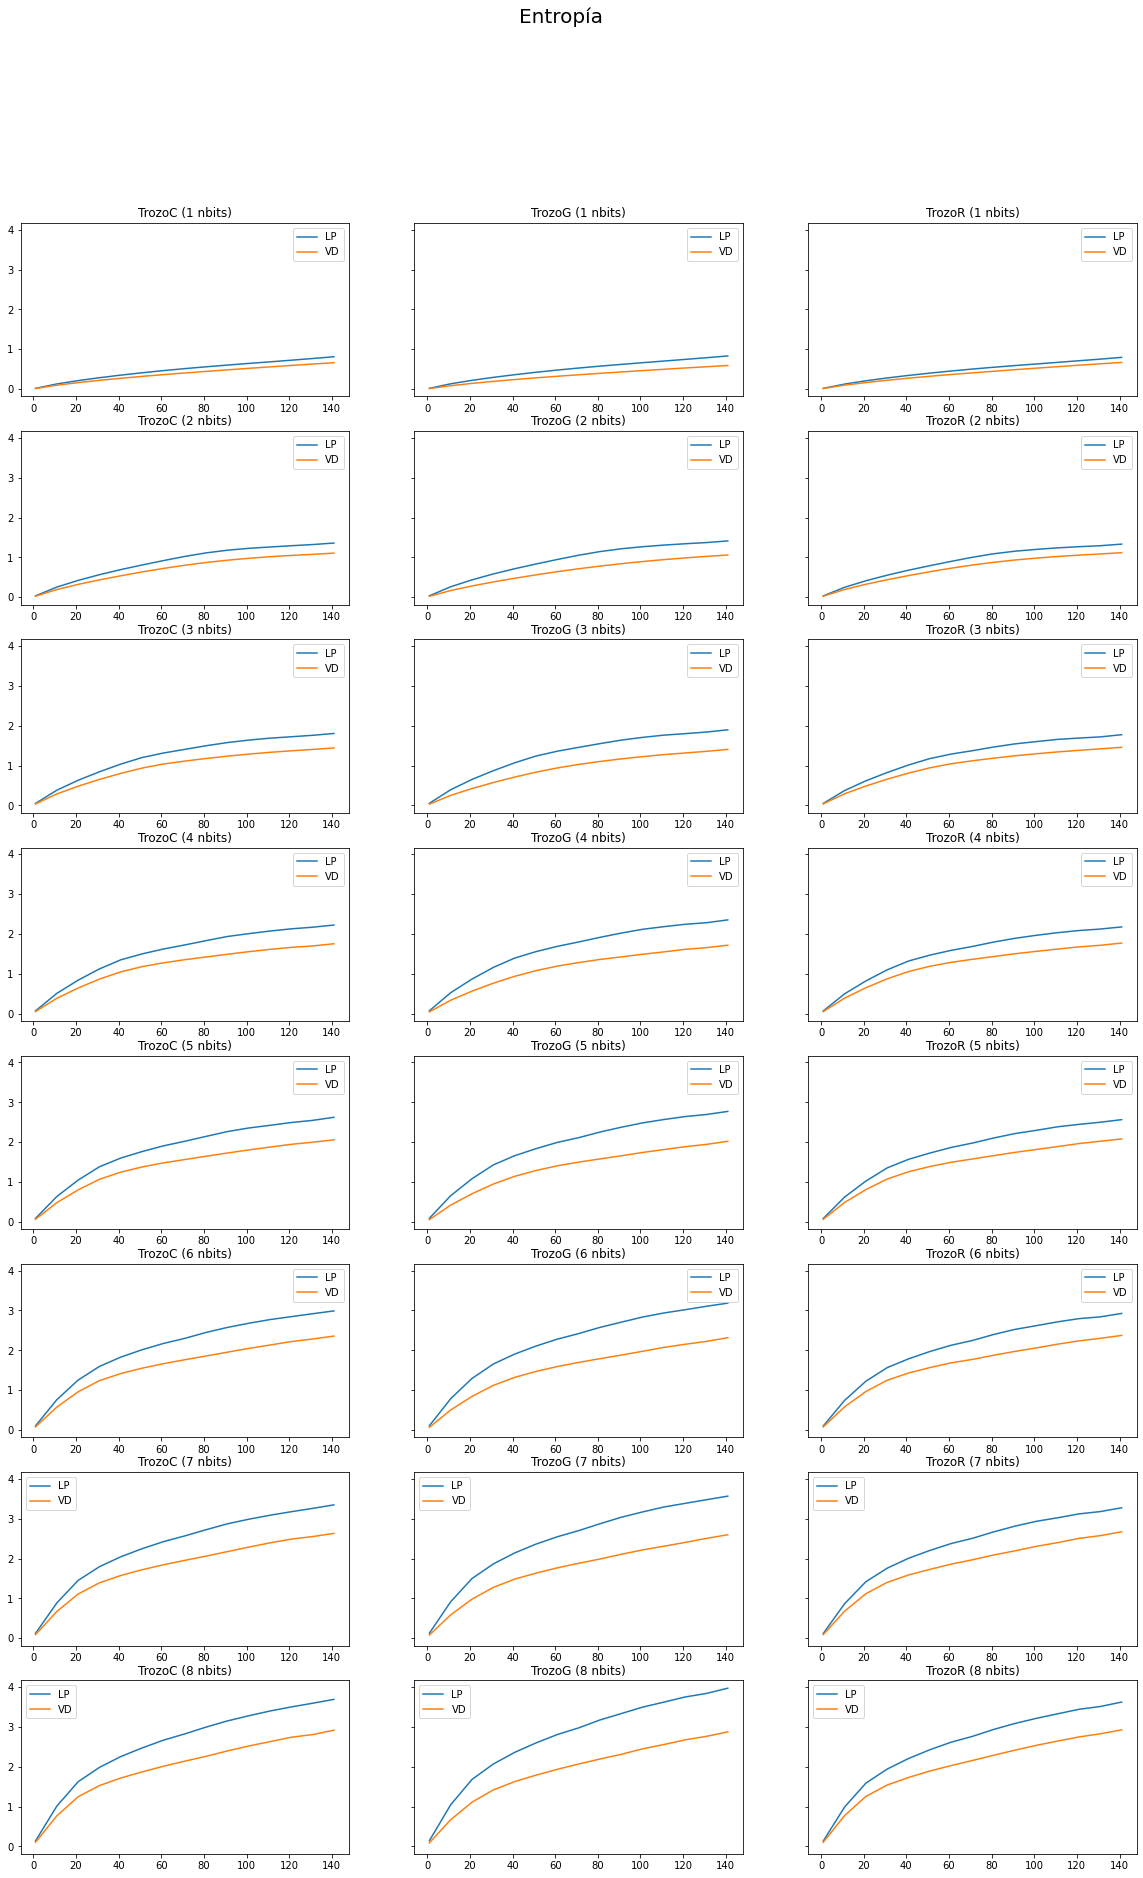

In [31]:
def plot_entropia(informationC,informationG,informationR, word_size, bin_size):
    """
        Plot entropy for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """
    fig, axes = plt.subplots(len(word_size), 3, figsize=(20, 30), sharey=True)
    plt.suptitle(f'Entropía', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['elp'],label='LP')
        row[0].plot(bin_size,informationC[nbits+1]['evd'],label='VD')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['elp'],label='LP')
        row[1].plot(bin_size,informationG[nbits+1]['evd'],label='VD')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['elp'],label='LP')
        row[2].plot(bin_size,informationR[nbits+1]['evd'],label='VD')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

En estas figuras se puede observar la entropía asociada a cada neurona cuando cambiamos el tamaño de palabra para cada tamaño de ventana. 

En todos los casos podemos observar como la entropía es mayor para la neurona LP que para la neurona VD. 

A medida se aumenta el tamaño de palabra, se puede observar como aumenta también la entropía. Esto es lógico, pues cuando el tamaño de palabra es superior, existen más combinaciones de palabras, por lo que las probabilidades se repartirán y la entropía aumentará.

### Información mutua

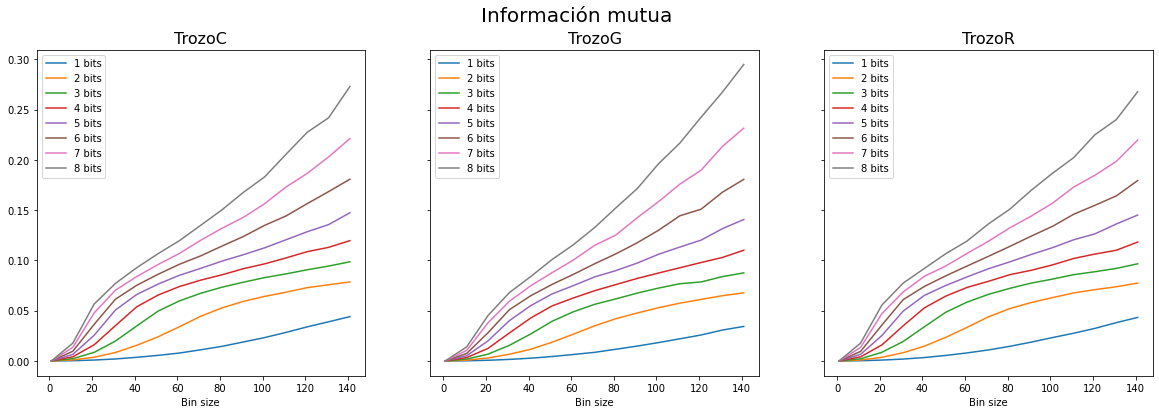

In [32]:
def plot_mutual_information(information_C, information_G, information_R, word_size, bin_size):
    """
        Plot mutual information for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(20, 6)
    plt.suptitle(f'Información mutua', fontsize=20)
    

    for nbits in word_size:
        ax1.plot(bin_size, information_C[nbits]['mi'], label = f"{nbits} bits")
    ax1.set_title("TrozoC", fontsize=16)
    ax1.set_xlabel("Bin size")
    ax1.legend()

    for nbits in word_size:
        ax2.plot(bin_size, information_G[nbits]['mi'], label = f"{nbits} bits")
    ax2.set_title("TrozoG", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    for nbits in word_size:
        ax3.plot(bin_size, information_R[nbits]['mi'], label = f"{nbits} bits")
    ax3.set_title("TrozoR", fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()
    
    plt.show()
    
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

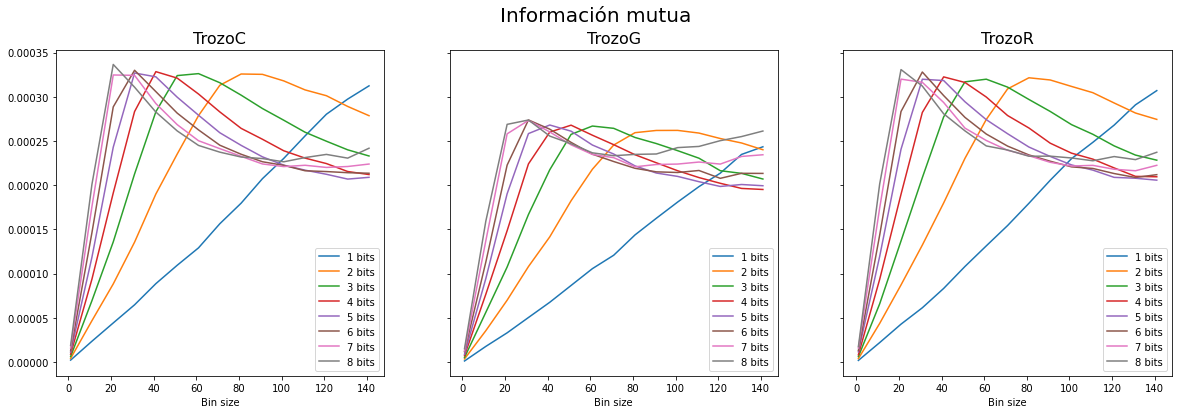

In [33]:
def plot_mutual_information_by_bin_size(information_C, information_G, information_R, word_size, bin_size):
    """
        Plot mutual information for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(20, 6)
    plt.suptitle(f'Información mutua', fontsize=20)
    

    for nbits in word_size:
        ax1.plot(bin_size, information_C[nbits]['mi']/bin_size/nbits, label = f"{nbits} bits")
    ax1.set_title("TrozoC", fontsize=16)
    ax1.set_xlabel("Bin size")
    ax1.legend()

    for nbits in word_size:
        ax2.plot(bin_size, information_G[nbits]['mi']/bin_size/nbits, label = f"{nbits} bits")
    ax2.set_title("TrozoG", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    for nbits in word_size:
        ax3.plot(bin_size, information_R[nbits]['mi']/bin_size/nbits, label = f"{nbits} bits")
    ax3.set_title("TrozoR", fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()
    
    plt.show()
    
plot_mutual_information_by_bin_size(information_C, information_G, information_R, word_size, bin_size)

Comentar esto

En este caso, se ha hecho una representación de la información mutua entre pares de neuronas para cada uno de los trozos en función del tamaño de palabra para distintos tamaños de ventana. 

En todos los casos se puede observar como la información mutua aumenta al aumentar el tamaño de palabra.

Cuando el tamaño de palabra es mayor, la probabilidad de encontrar instantes con un cero disminuye, entonces la información transmitida entre las neuronas será superior. 

### Transmisión de información entre neuronas

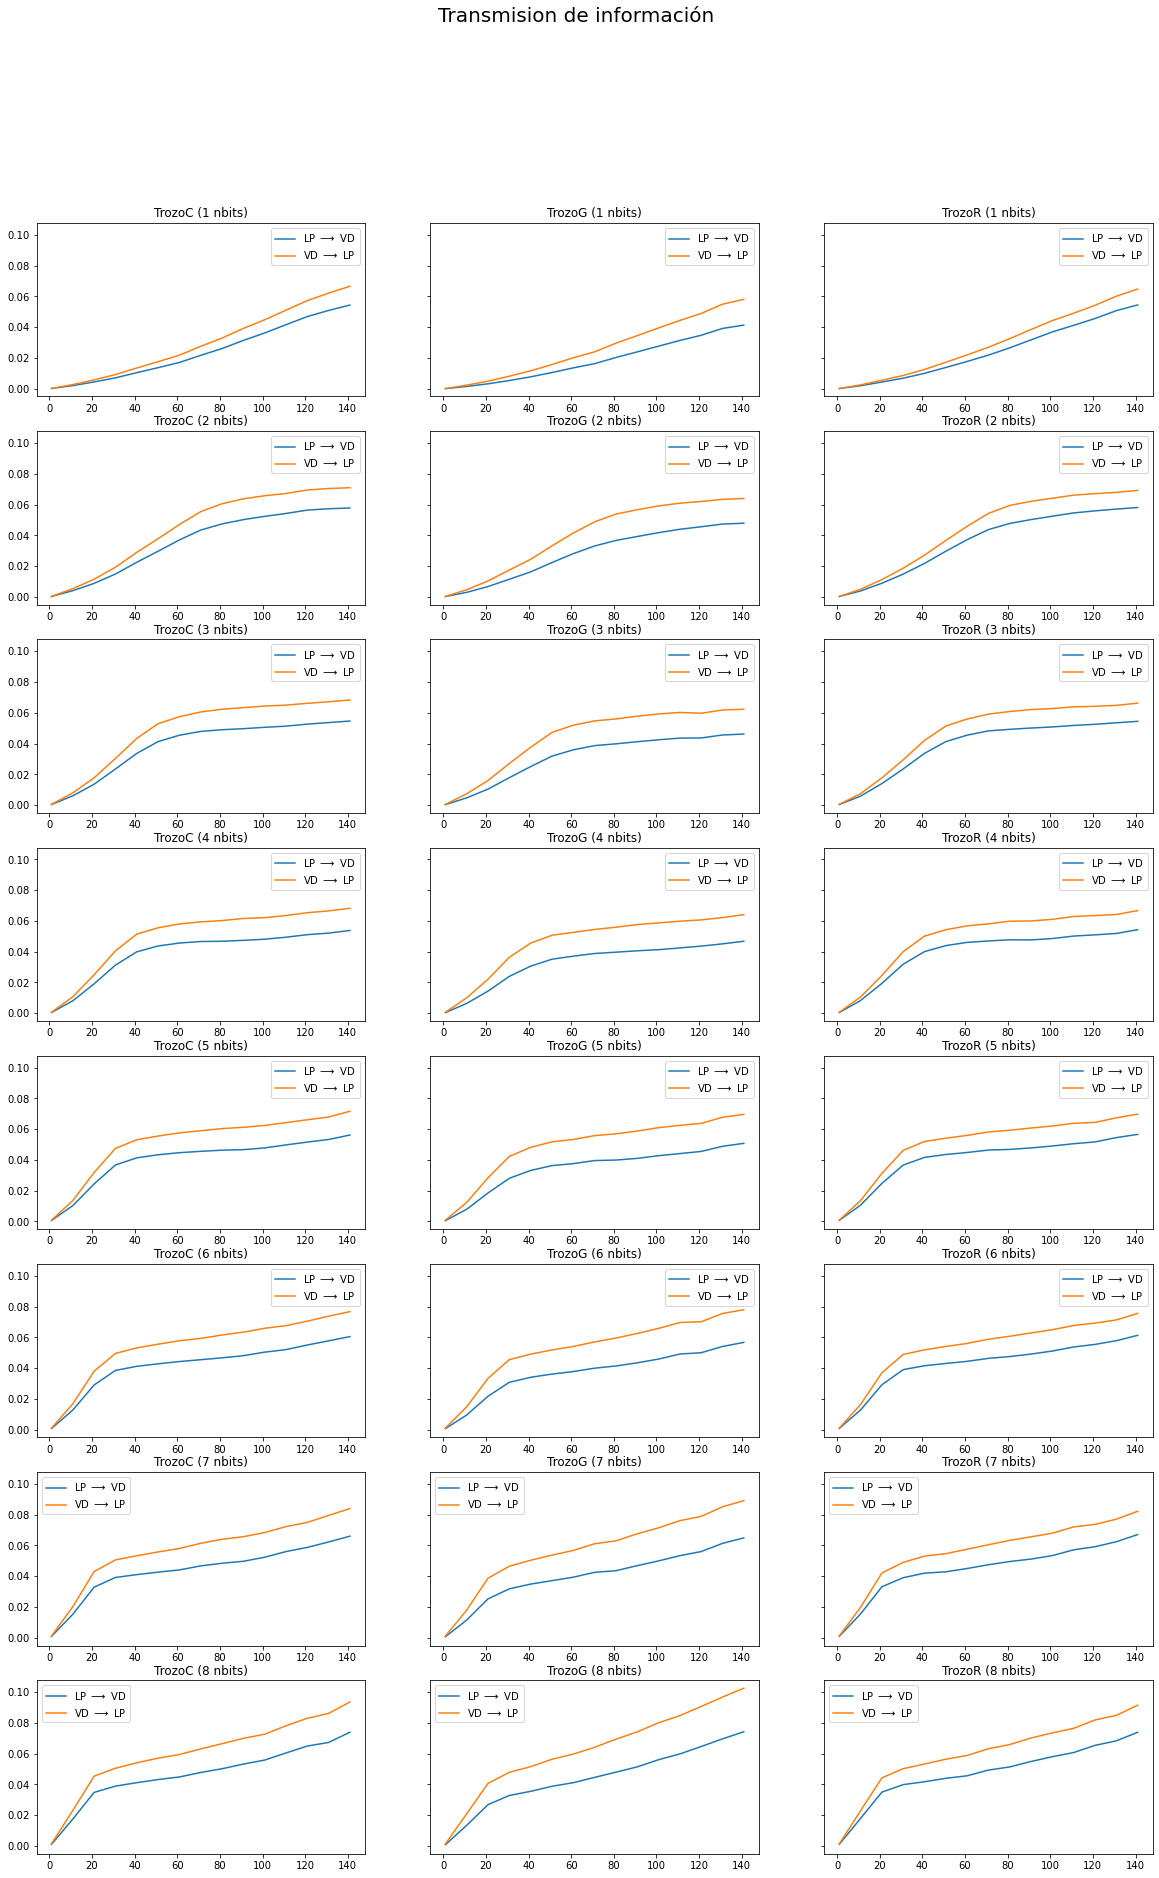

In [34]:
def plot_transfer_info(informationC,informationG,informationR, word_size, bin_size):
    """
        Plot transfer info for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """
    fig, axes = plt.subplots(len(word_size), 3, figsize=(20, 30), sharey=True)
    plt.suptitle(f'Transmision de información', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[0].plot(bin_size,informationC[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[1].plot(bin_size,informationG[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[2].plot(bin_size,informationR[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

Por último, hemos representado la transmisión de información entre neuronas, para distintos tamaños de ventana y en función del tamaño de palabra. De esta manera, se puede detectar cual es la neurona transmisora de información y cual es la receptora. Tras analizar la entropía para ambas neuronas, hemos visto que la neurona con mayor entropía es la neurona LP, esto está asociado a una transmisión de información mayor de la neurona VD a la neurona LP.

Al analizar la transmisión de información entre neuronas, podemos observar como se cumple lo que se podía predecir al estudiar únicamente la entropía de las neuronas; la transmisión de información es mayor de la neurona VD a la neurona LP. 

Además, se puede observar como la transmisión de información entre neuronas deja de aumentar de manera tan notable para tamaños de palabra grande a partir de tamaños de ventana grandes. 

## Representamos la entropía, MI y TI usando palabras deslizantes.

Ahora, haremos uso de tamaños palabras deslizantes en lugar de tamaños de palabra fijos.

### Entropía

In [35]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, False)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, False)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, False)

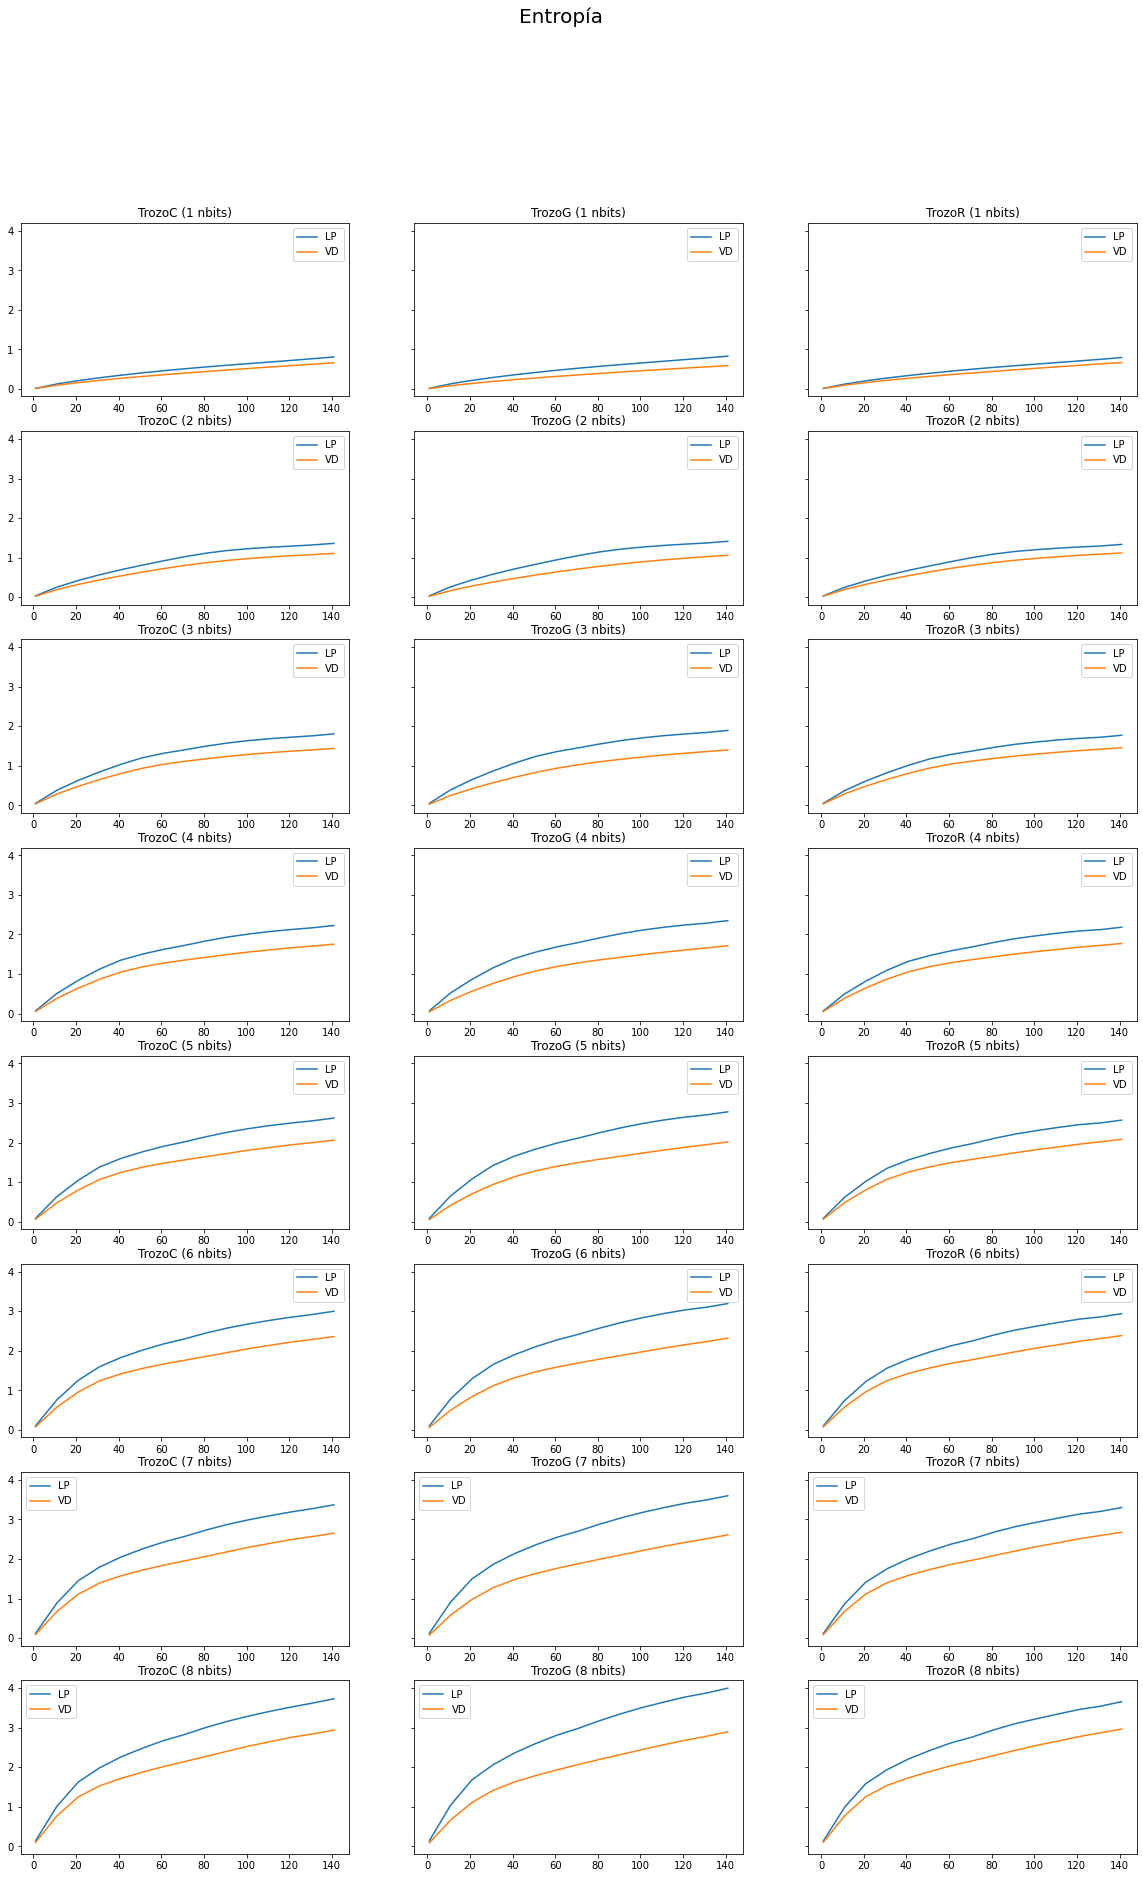

In [36]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

### Información mutua

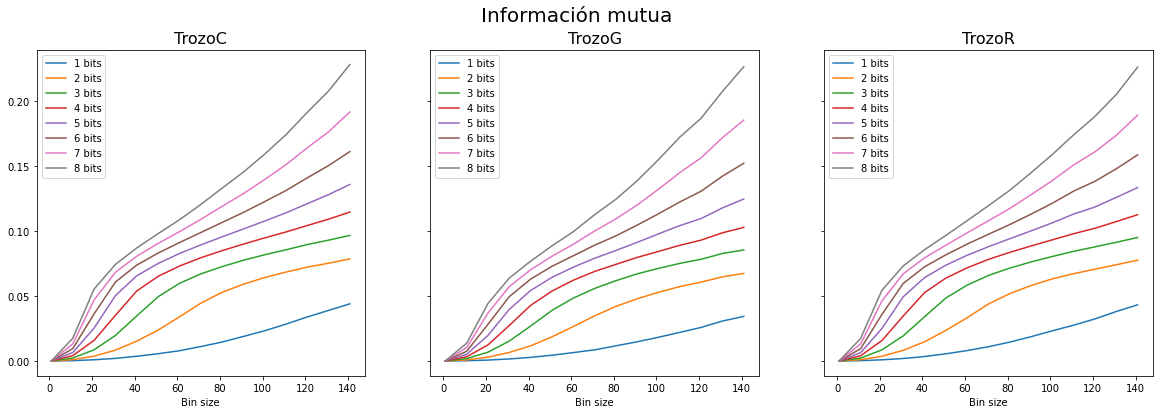

In [37]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

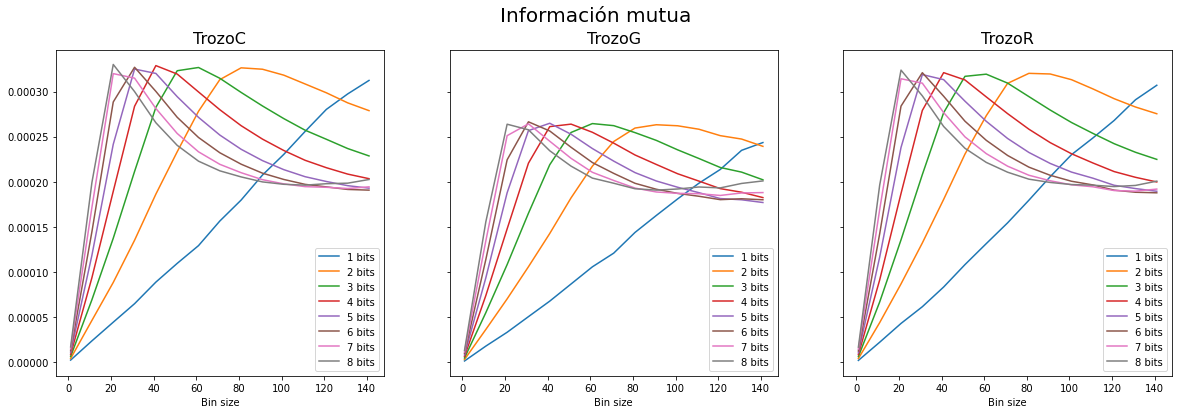

In [38]:
plot_mutual_information_by_bin_size(information_C, information_G, information_R, word_size, bin_size)

### Transmisión de información

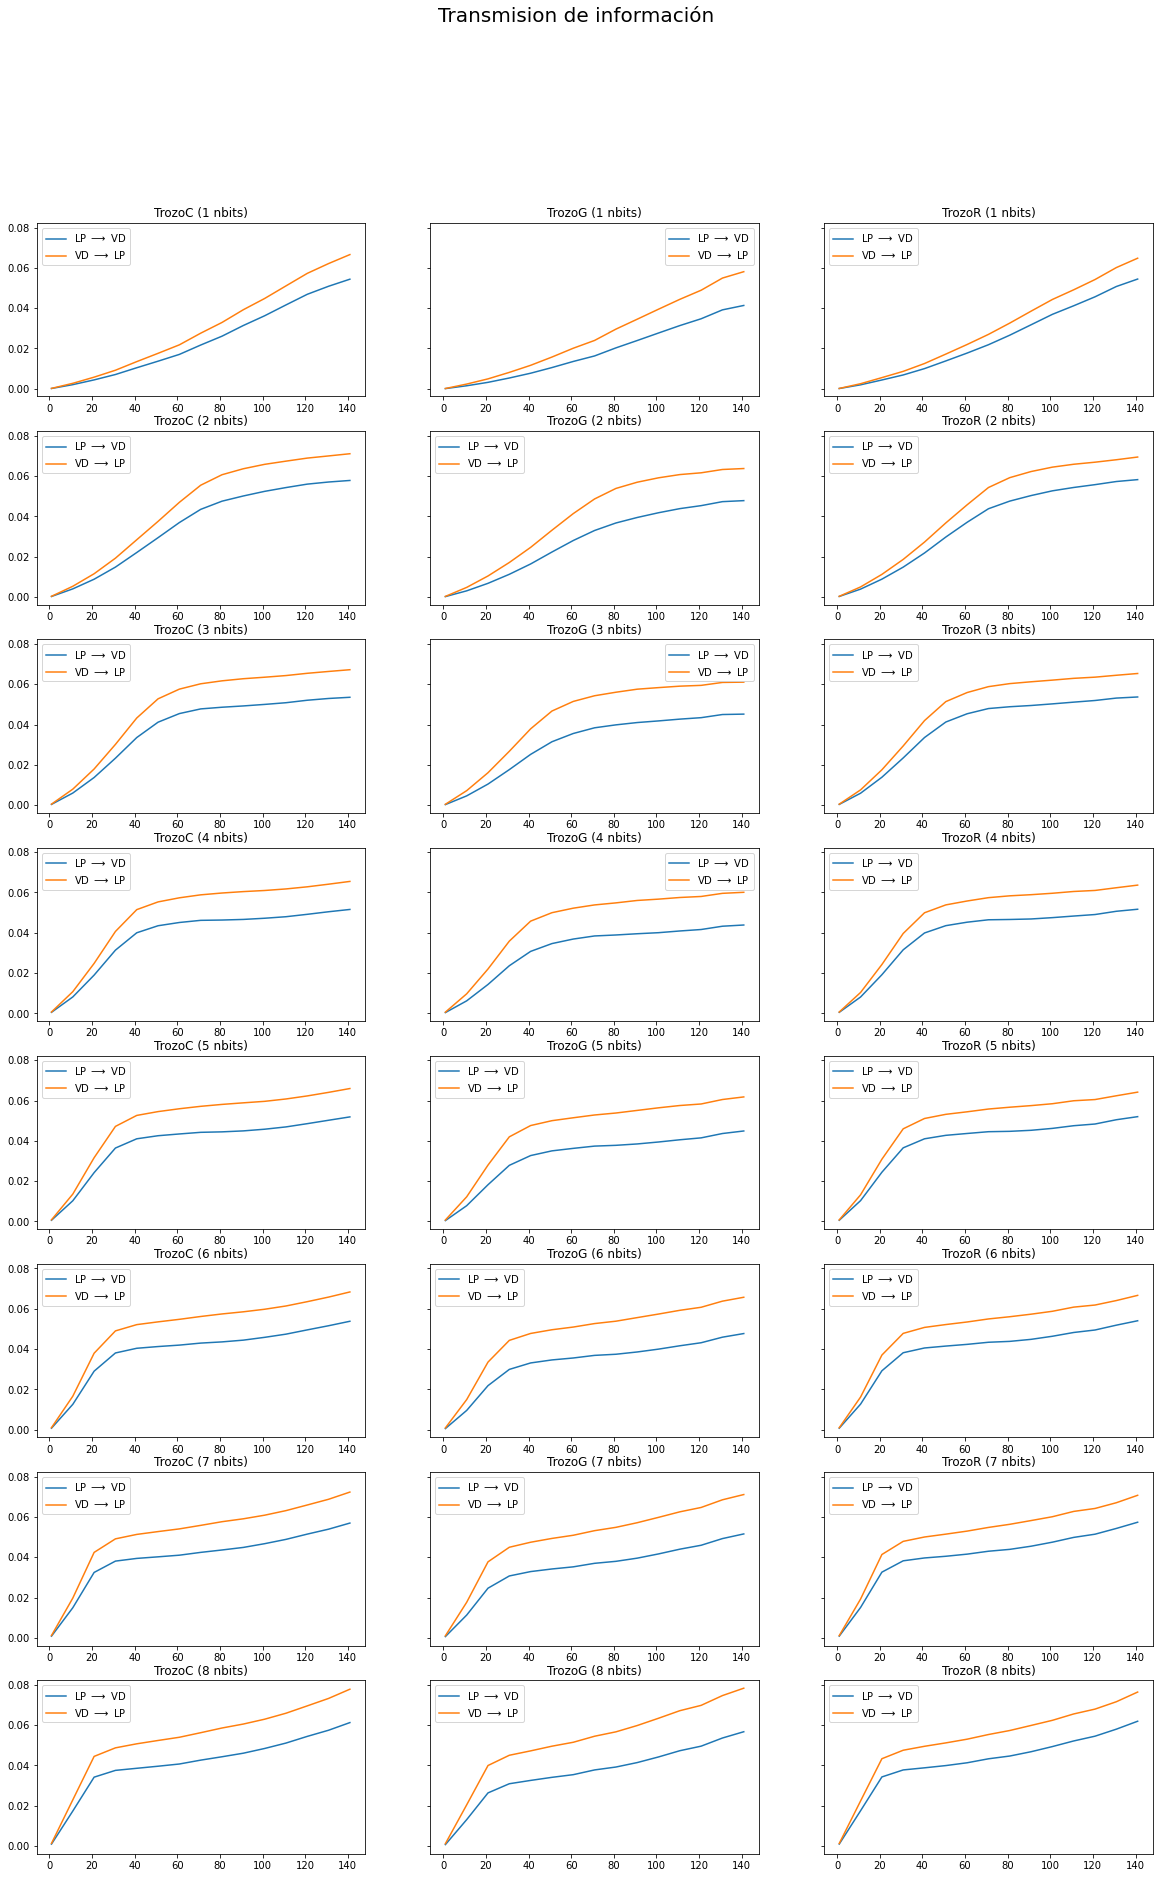

In [39]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

En este caso, se puede observar de nuevo lo mismo que se ha observado anteriormente para tamaños de palabra fija. 

# ANÁLISIS DE DATOS A TRAVÉS DE LOS BURST

Ahora, realizaremos el análisis de la información haciendo uso de los burst en lugar de los spikes. Como sabemos, los burst son agrupaciones de spikes. 

Tras estudiar las gráficas donde se han representado los spikes en función del tiempo, se puede observar que los burst ocurren durante un periodo aproximado de 2500 unidades temporales.

In [40]:
#plot_original_signal_and_transformed_signal(df_c[0:20000], trozoC_t[0:20000]*df_c[0:20000], umbral_c, "Trozo_C")
#plot_original_signal_and_transformed_signal(df_g[0:20000], trozoG_t[0:20000]*df_g[0:20000], umbral_g, "Trozo_G")
#plot_original_signal_and_transformed_signal(df_r[0:20000], trozoR_t[0:20000]*df_r[0:20000], umbral_r, "Trozo_R")

Para detectar estos burst, haremos de nuevo uso de la función "find_peaks" tal que la distancia entre estos eventos sea superior a 2500 unidades temporales.

In [41]:
def hallar_burst(df, nombre, umbral, distancia=1, n=50000):
  print("________________ {0} ________________".format(nombre))
  lp_events, _ = sgn.find_peaks(df.LP[:n], umbral[0], distance = distancia)
  vd_events, _ = sgn.find_peaks(df.VD[:n], umbral[1], distance = distancia)
    
  t_lp,_ = sgn.find_peaks(df.LP, umbral[0],distance = distancia)
  t_vd,_ = sgn.find_peaks(df.VD, umbral[1],distance = distancia)
  print("Total events (LP): {0}".format(len(t_lp)))
  print("Total events (VD): {0}".format(len(t_vd)))

  fig, axs = plt.subplots(1, 2, figsize =(16, 6))
  fig.suptitle('{0}'.format(nombre), fontsize=20)

  for j in range(2):
    axs[j].set_title(list(df)[j])
    axs[j].plot(df.iloc[0:50000,j], lw=0.3)
    axs[j].grid(True)

    xmin, xmax = axs[j].get_xlim()
    axs[j].plot([xmin, xmax], 2*[umbral[j]], label="Umbral", color = "green")
    axs[j].legend()

    axs[0].plot(lp_events, df.iloc[:,0][lp_events], "x", color="black")
    axs[1].plot(vd_events, df.iloc[:,1][vd_events], "x", color="black")

  return t_lp, t_vd



________________ TrozoC ________________
Total events (LP): 2800
Total events (VD): 2168
________________ TrozoG ________________
Total events (LP): 2643
Total events (VD): 1989
________________ TrozoR ________________
Total events (LP): 2277
Total events (VD): 1801


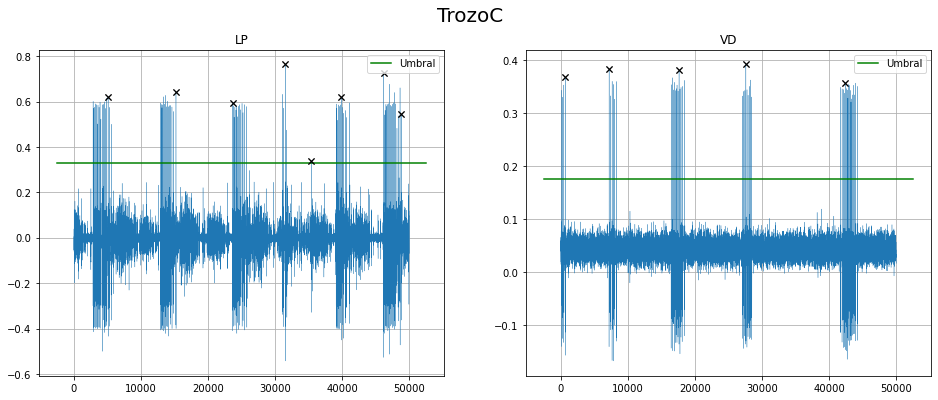

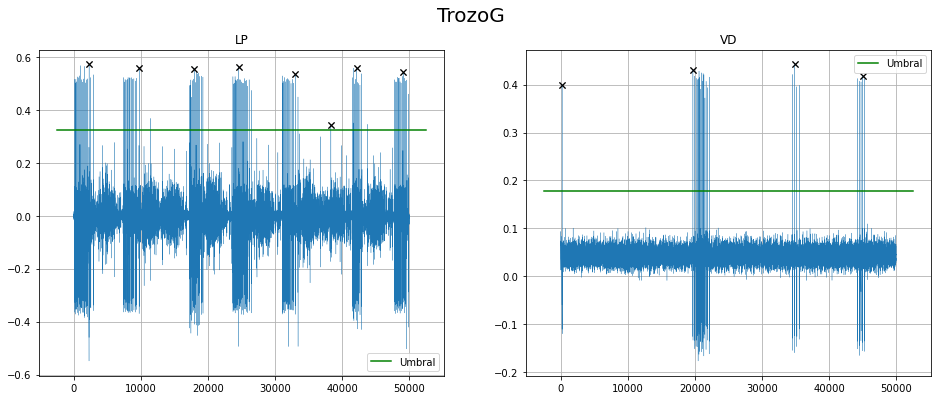

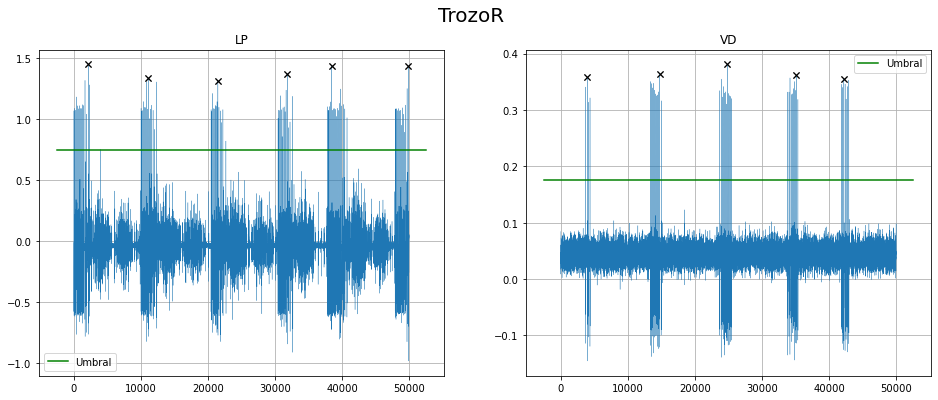

In [42]:
lp_bursts_C, vd_bursts_C = hallar_burst(df_c, 'TrozoC', umbral_c, 2500)
lp_bursts_G, vd_bursts_G = hallar_burst(df_g,'TrozoG', umbral_g, 2500)
lp_bursts_R, vd_bursts_R = hallar_burst(df_r,'TrozoR', umbral_r, 2500)

Se puede observar que aproximadamente un 0.01 % de los eventos totales corresponden a burst. Es decir, aparece aproximadamente un burst para cada 10 spikes. 

Ahora, haremos un análisis igual al análisis previo que hemos hecho. 

________________ TrozoC ________________
________ LP ________
Min: 2500
Max: 22873
Mean: 7087.801000357271
Medium: 7154.0
________ VD ________
Min: 2500
Max: 32748
Mean: 9155.056299030919
Medium: 8991.0
________________ TrozoG ________________
________ LP ________
Min: 2501
Max: 16114
Mean: 6197.456093868282
Medium: 6124.5
________ VD ________
Min: 2500
Max: 23574
Mean: 8238.16046277666
Medium: 7887.0
________________ TrozoR ________________
________ LP ________
Min: 2501
Max: 25385
Mean: 7196.277680140597
Medium: 7246.5
________ VD ________
Min: 2500
Max: 32748
Mean: 9099.687222222223
Medium: 8946.0


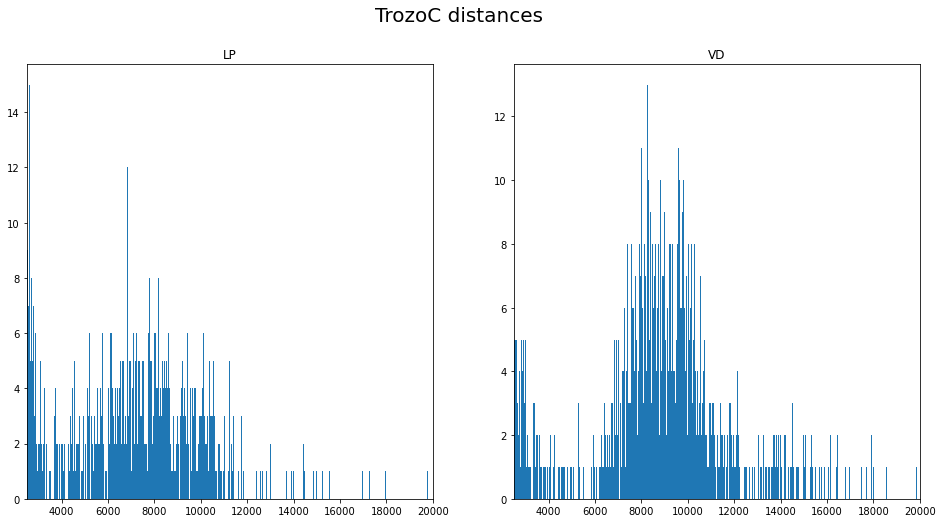

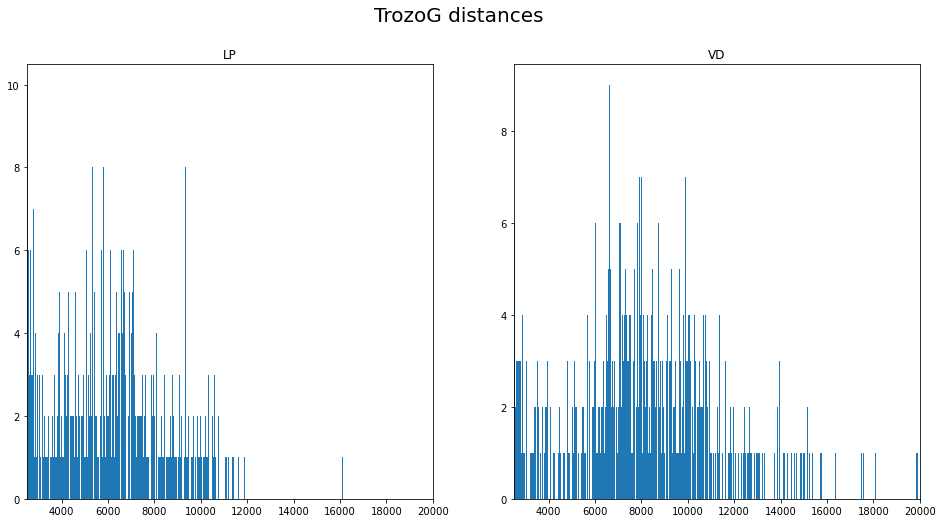

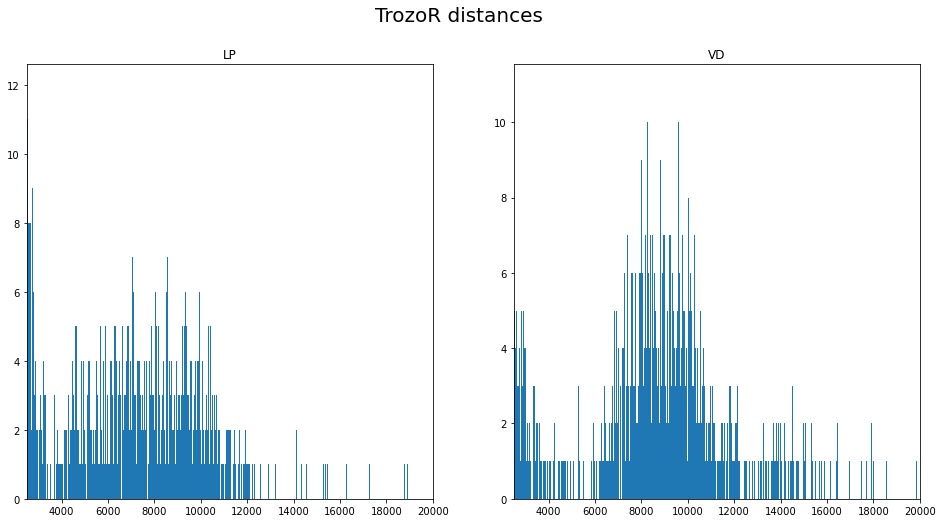

In [43]:
stats_spikes('TrozoC', lp_bursts_C, vd_bursts_C, 2500, 20000)
stats_spikes('TrozoG', lp_bursts_G, vd_bursts_G, 2500, 20000)
stats_spikes('TrozoR', lp_bursts_R, vd_bursts_R, 2500, 20000)

Estudiando los histogramas, se puede observar que la distancia más común entre burst corresponde a aproximadamente 8000 unidades. Entonces, realizaremos el análisis para distancias no superiores a 10000 unidades, pues el error aumentará notablemente cuando sobrepasemos esta cantidad.

A continuación, realizaremos una discretización similar a la que habíamos hecho con los spikes, pero ahora con bursts.

In [44]:
def show_discretize_burst(df, nombre, n):
    """
        Show the first n binary encoding for bursts (burst = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            name (str): name of chunk to analyze
            n (int): n records to show

    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    plt.suptitle('Discretize {0}'.format(nombre), fontsize=20)
    ax1.set_title("LP", fontsize=16)
    ax1.plot(df[f'LP_bursts'].iloc[:n], "tab:red", lw=0.6, label = 'LP')
    ax1.plot(df[f'LP'].iloc[:n],'tab:blue',lw=0.6, label='VD')
    
    ax2.plot(df[f'VD_bursts'].iloc[:n], "tab:red",lw=0.6, label = 'LP')
    ax2.plot(df[f'VD'].iloc[:n],'tab:blue',lw=0.6, label='VD')
    ax2.set_title("VD", fontsize=16)


def discretize_by_bursts(df, lp_bursts, vd_bursts):
    """
        Binary encoding for bursts (burst = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            lp_bursts (numpy): index of lp bursts found
            vd_bursts (numpy): index of vd bursts found

    """

    df["LP_bursts"] = 0
    df.loc[lp_bursts, "LP_bursts"] = 1
    df["VD_bursts"] = 0
    df.loc[vd_bursts, "VD_bursts"] = 1
    return df

In [45]:
def codificacion_señal(df, lp_spikes, vd_spikes):
  df["LP_picos"] = 0
  df.loc[lp_spikes, "LP_picos"] = 1
  df["VD_picos"] = 0
  df.loc[vd_spikes, "VD_picos"] = 1

def plot_señales_discretizadas(df, nombre, n):
  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.set_size_inches(16, 8)
  plt.suptitle('Discretize {0}'.format(nombre), fontsize=20)
  ax1.plot(df["LP_picos"].iloc[:n],lw=0.6)
  ax1.set_title("LP", fontsize=16)
  ax2.plot(df["VD_picos"].iloc[:n],'tab:red',lw=0.6)
  ax2.set_title("VD", fontsize=16)

In [46]:
trozoC = discretize_by_bursts(df_c, lp_bursts_C, vd_bursts_C)
trozoG = discretize_by_bursts(df_g, lp_bursts_G, vd_bursts_G)
trozoR = discretize_by_bursts(df_r, lp_bursts_R, vd_bursts_R)

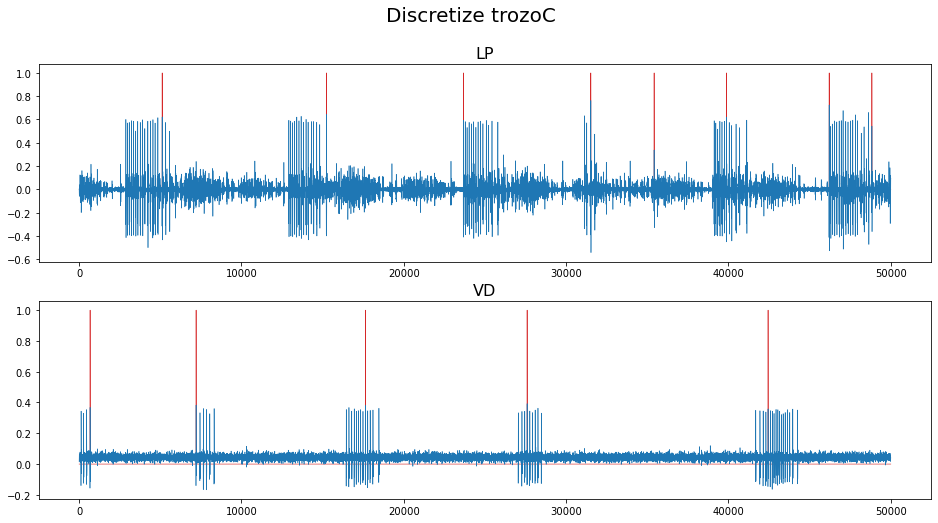

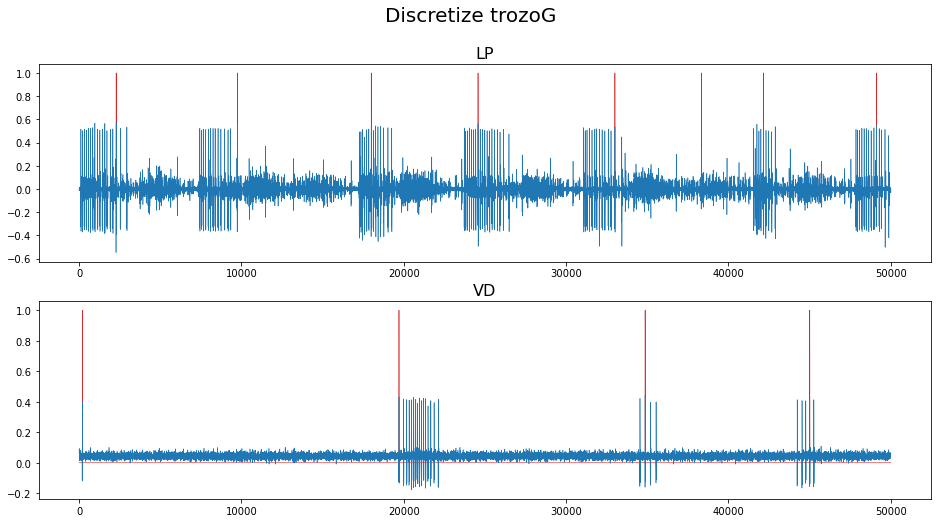

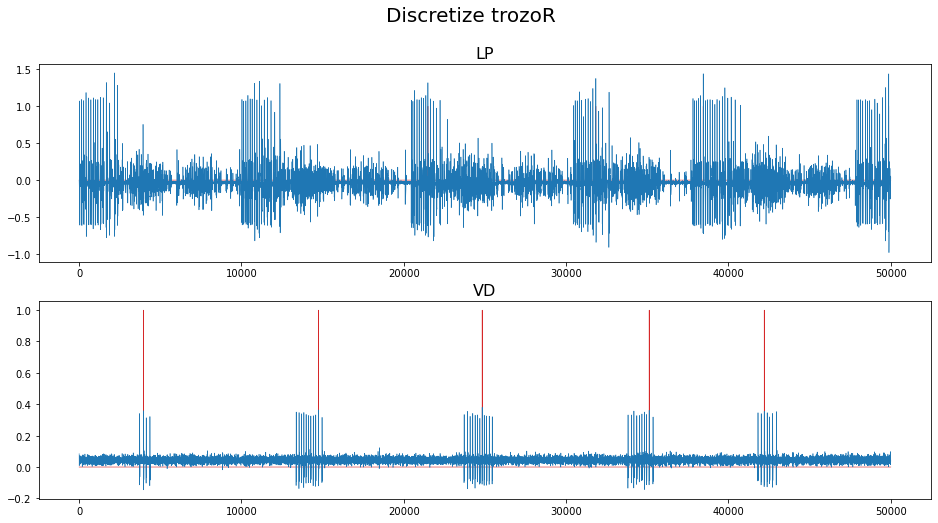

In [47]:
show_discretize_burst(trozoC, 'trozoC', 50000)
show_discretize_burst(trozoG, 'trozoG', 50000)
show_discretize_burst(trozoR, 'trozoR', 50000)

# Entropía, información mutua y transmisión de información

In [48]:
bin_size = range(1, 6000, 100)

lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, df = trozoC, coding = 'bursts')
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, df = trozoG, coding = 'bursts')
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, df = trozoR, coding = 'bursts')

En primer lugar, lo hacemos para tamaños de palabra fijos:

In [49]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, True)

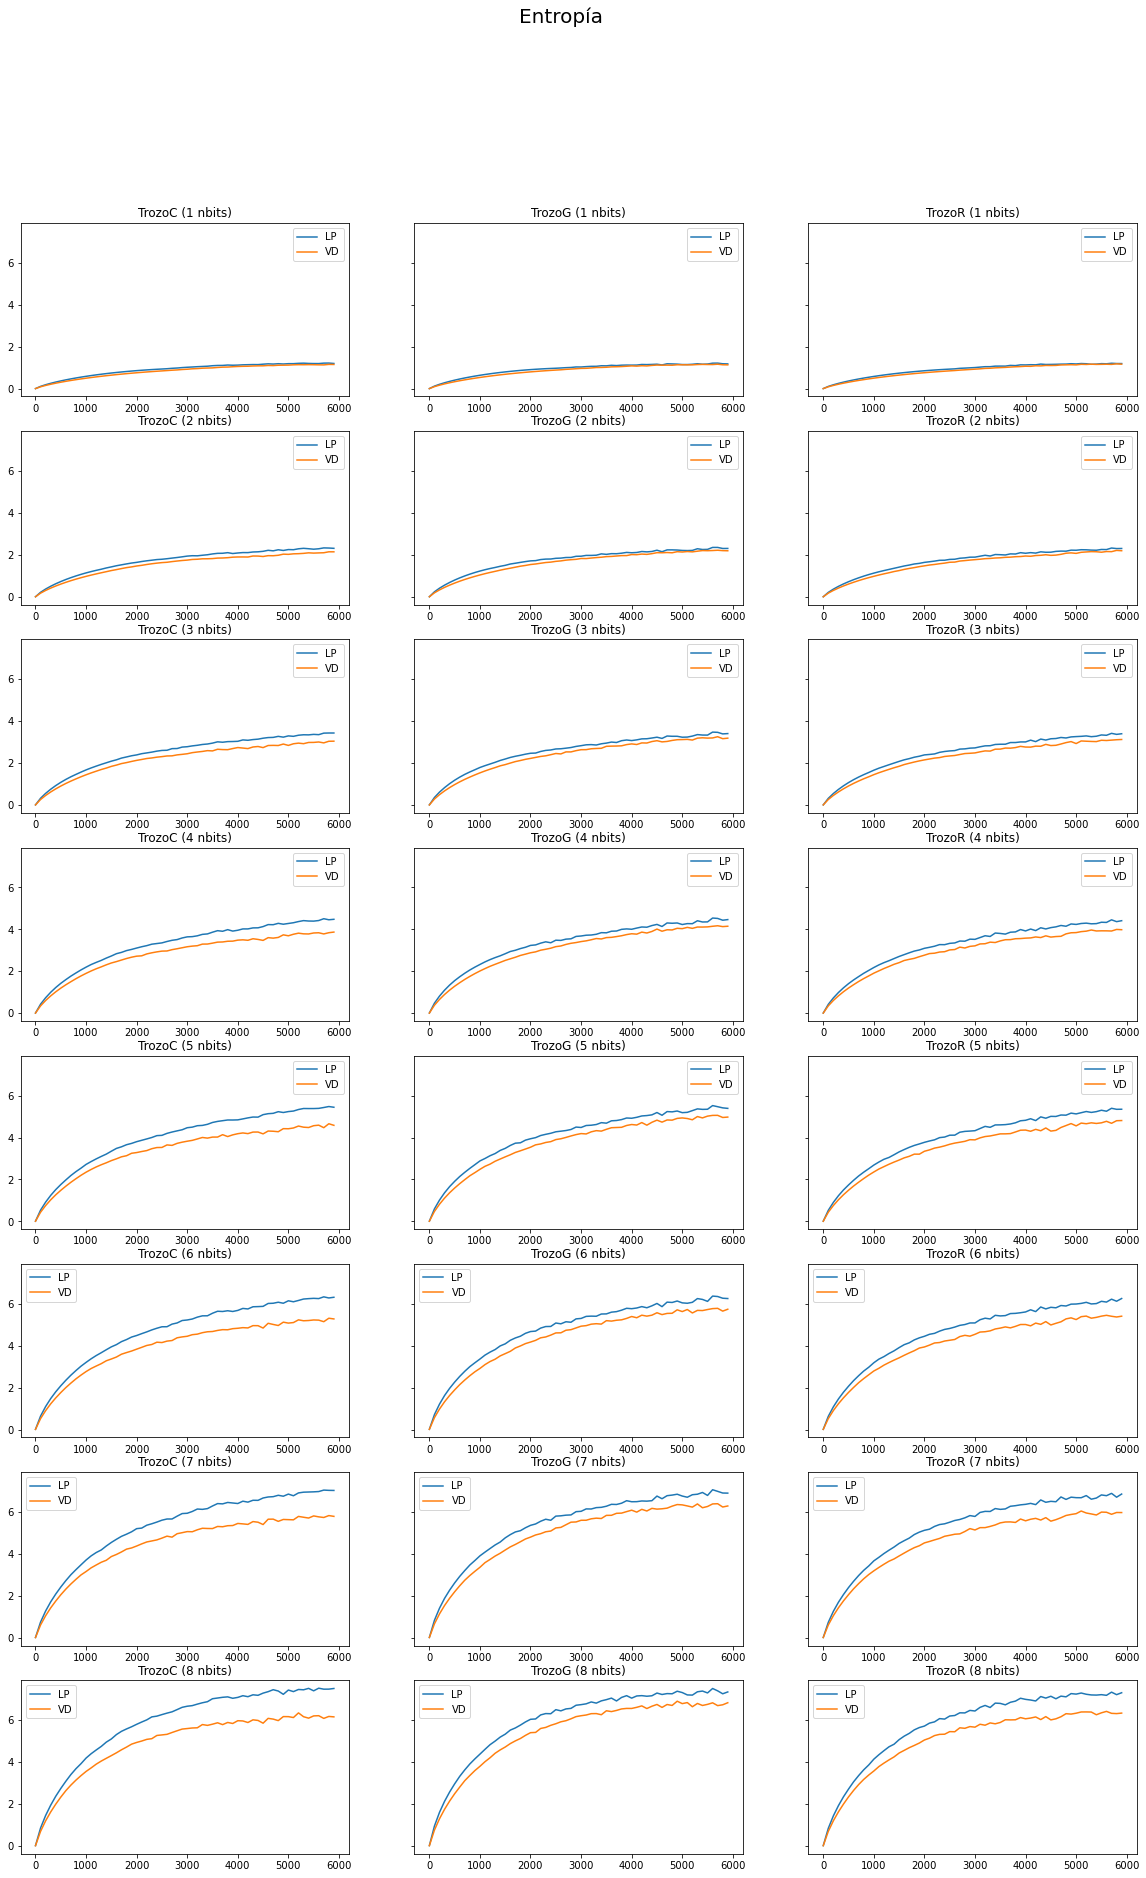

In [50]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

En primer lugar, lo que se puede observar al representar la entropía es que para tamaños de palabra pequeños, la entropía para ambas neuronas es similar, mientras que a medida se va aumentando este tamaño, se puede observar como la entropía asociada a la neurona LP es mayor a la de la neurona VD.

A diferencia del caso anterior, la entropía en este caso es superior a la obtenida analizando los spikes, y por ende, habrá una transmisión de información mayor. 

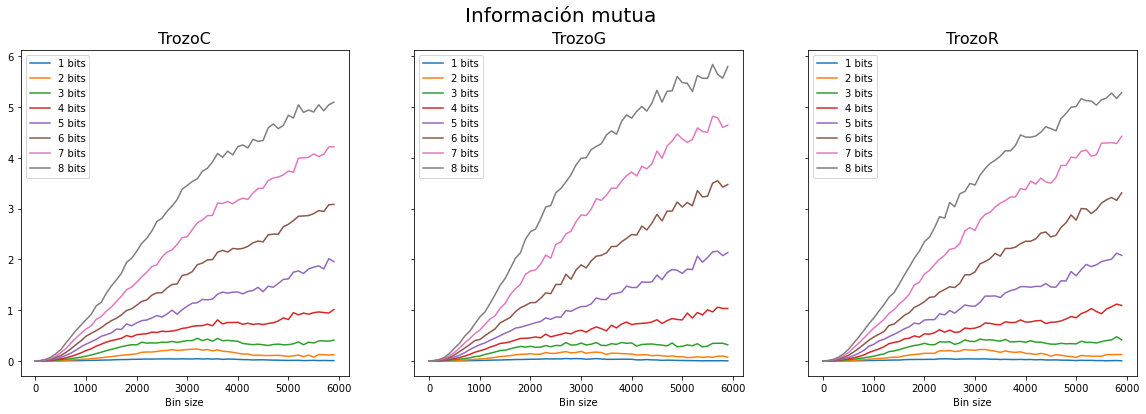

In [51]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

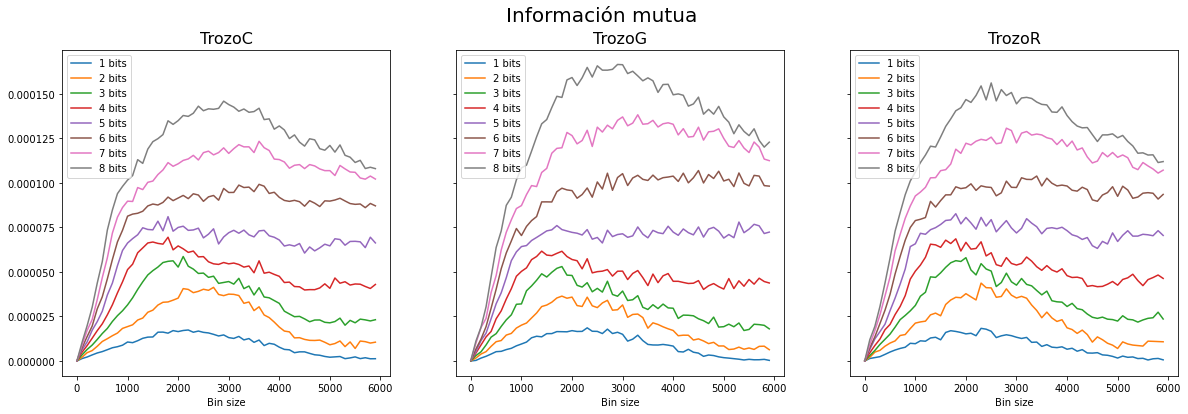

In [52]:
plot_mutual_information_by_bin_size(information_C, information_G, information_R, word_size, bin_size)

La información mutua sigue un comportamiento similar al caso donde se estudiaban los spikes. 

De nuevo, la información mutua aumenta al aumentar el tamaño de la palabra. 

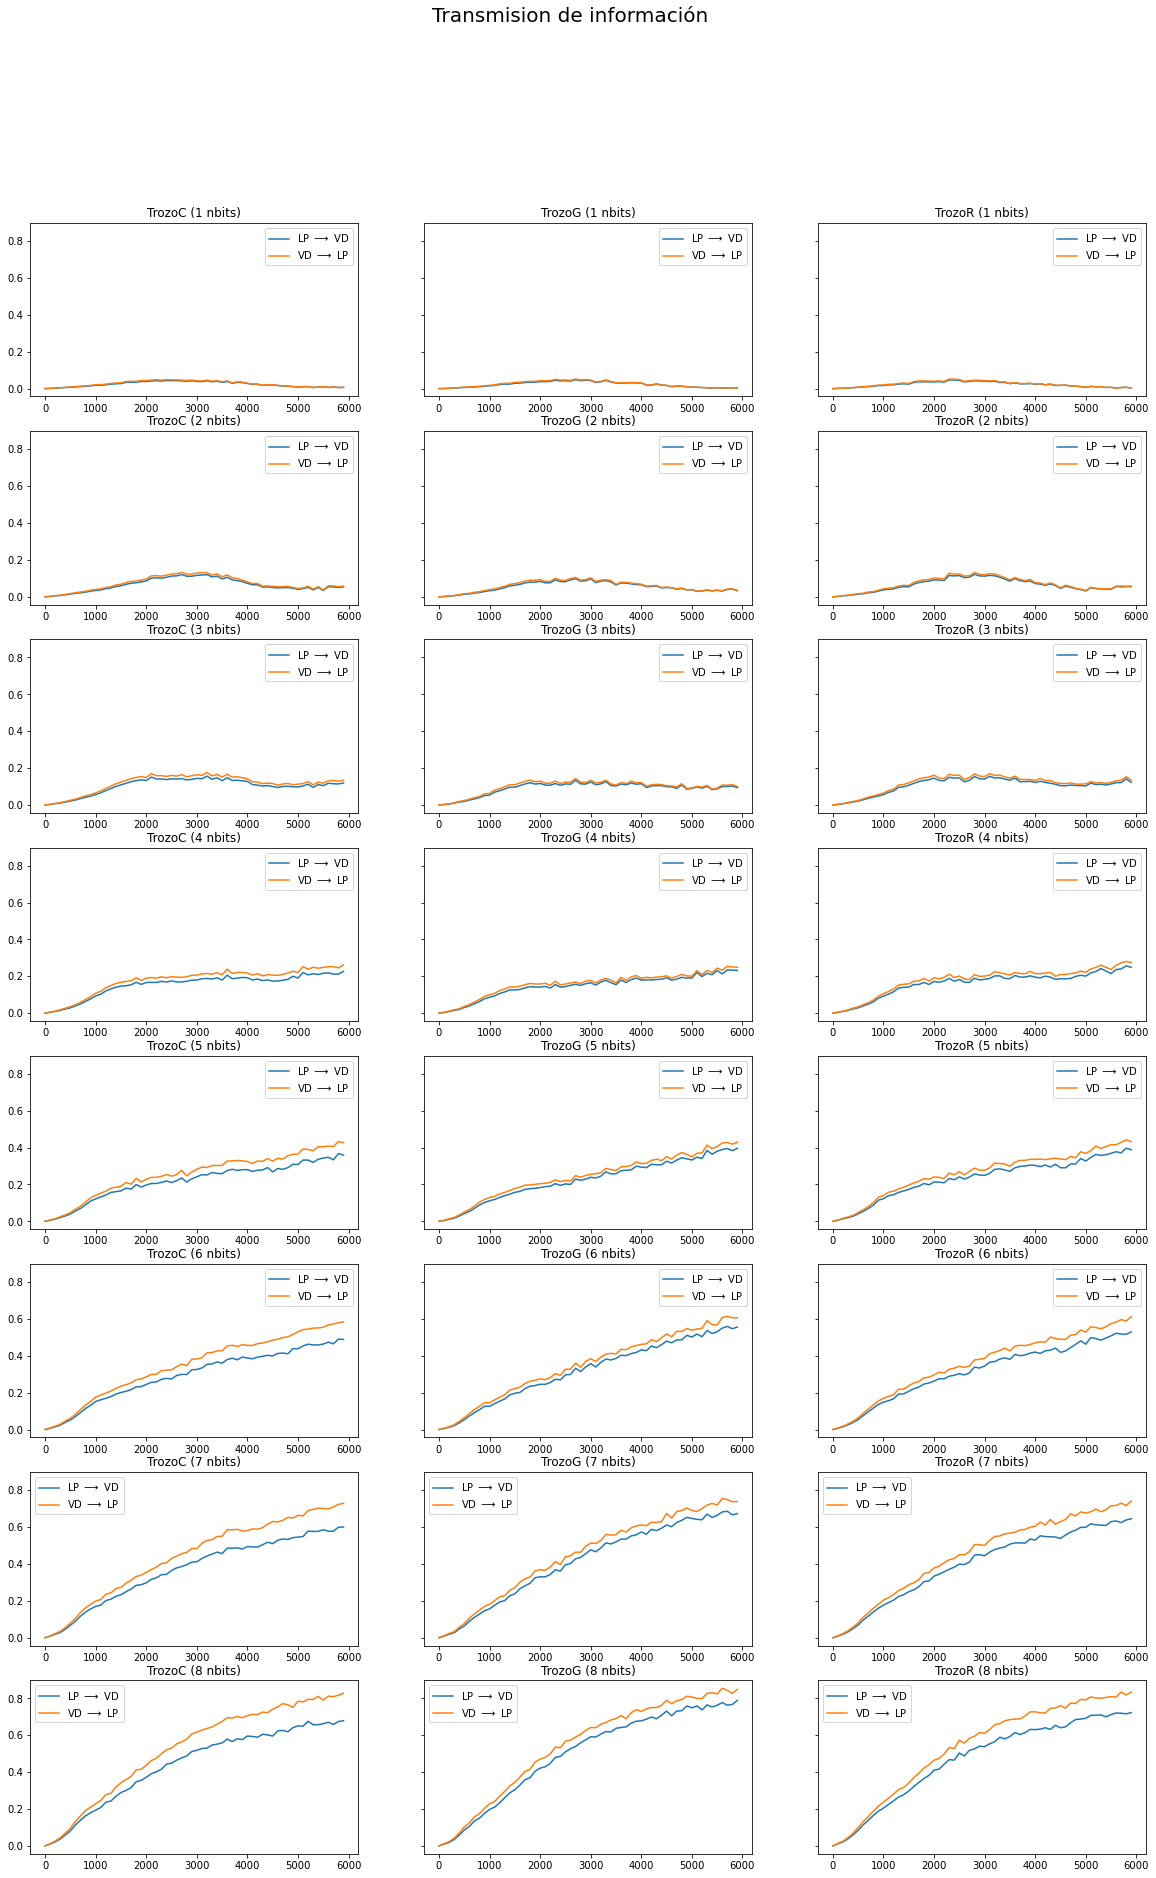

In [53]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

Estudiando la transmisión de información entre neuronas, obtenemos de nuevo que esta es mayor desde la neurona VD a la neurona LP que al revés, lo mismo que obteníamos para los spikes.

Ahora, haremos uso de palabras deslizantes en lugar de palabras fijas. 

In [54]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, False)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, False)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, False)

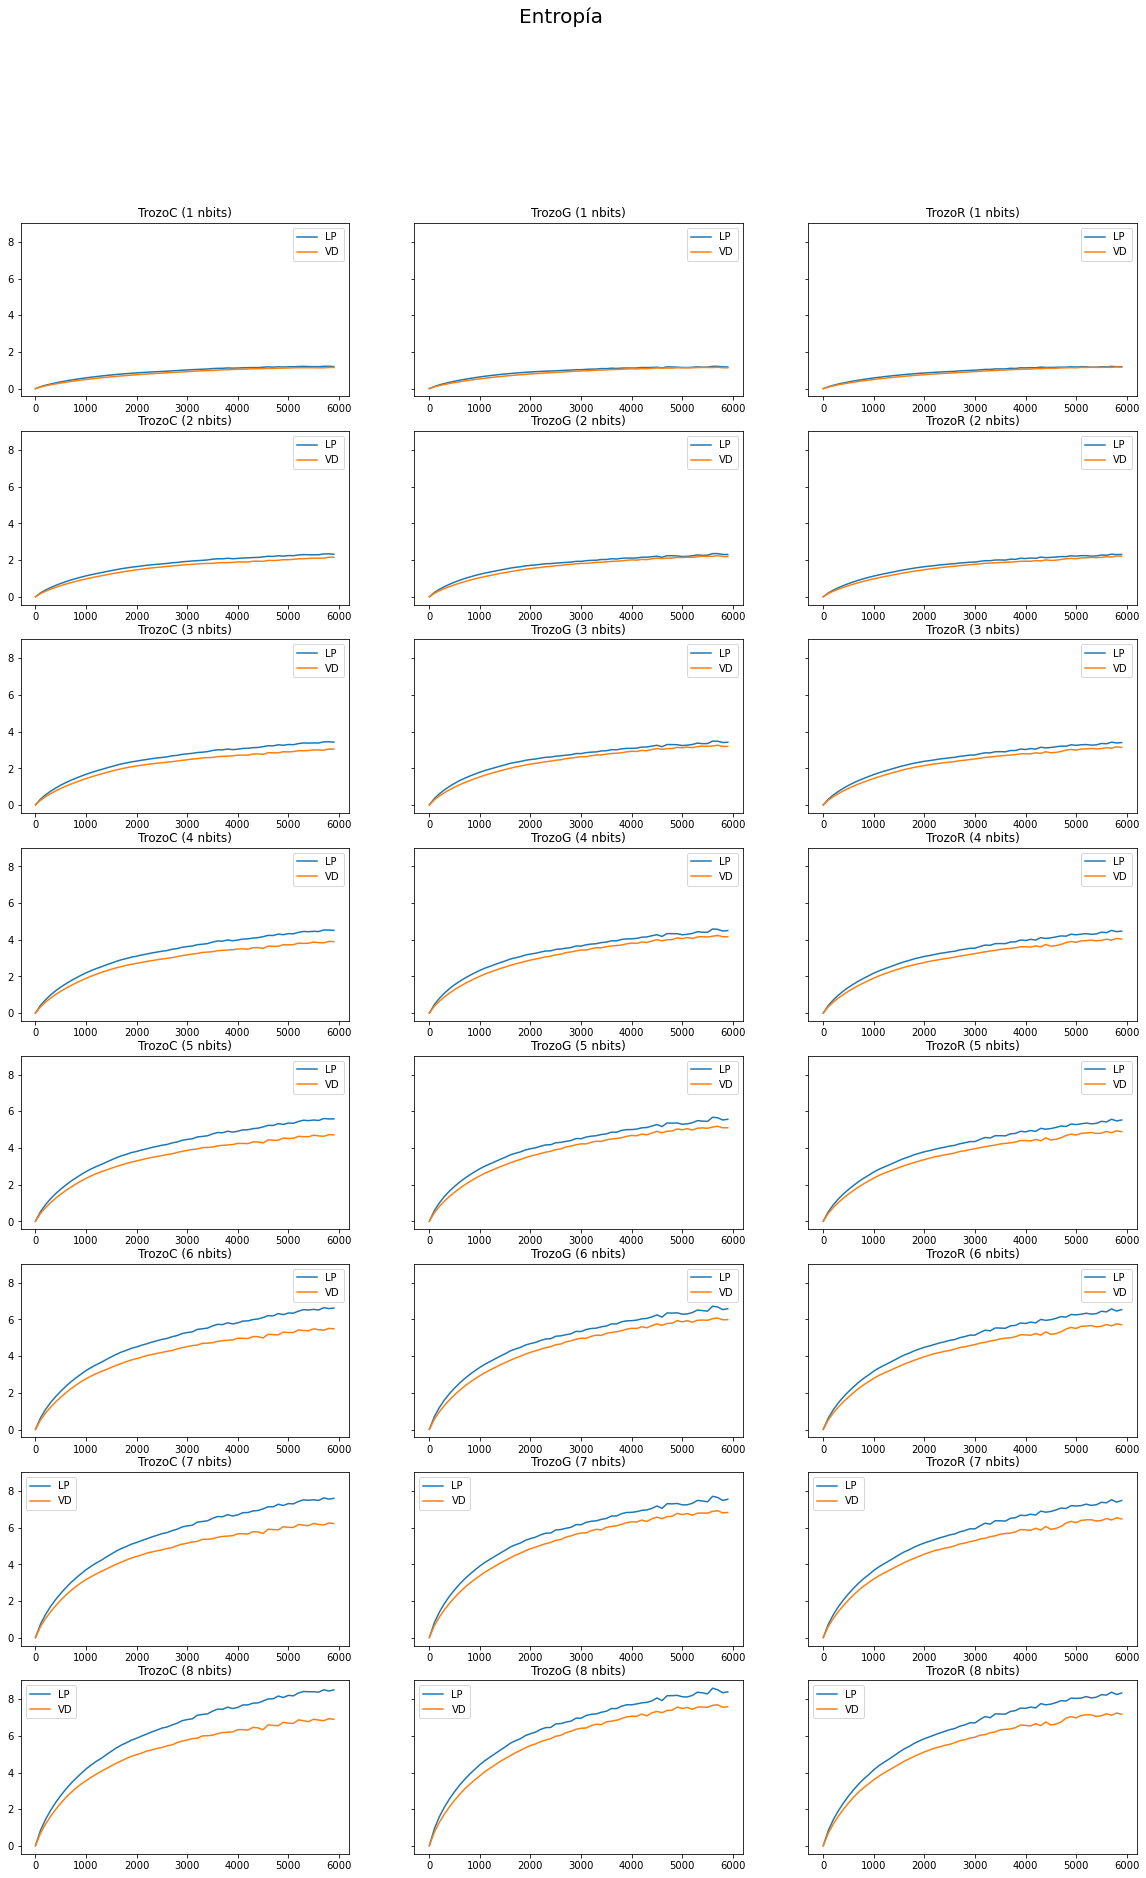

In [55]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

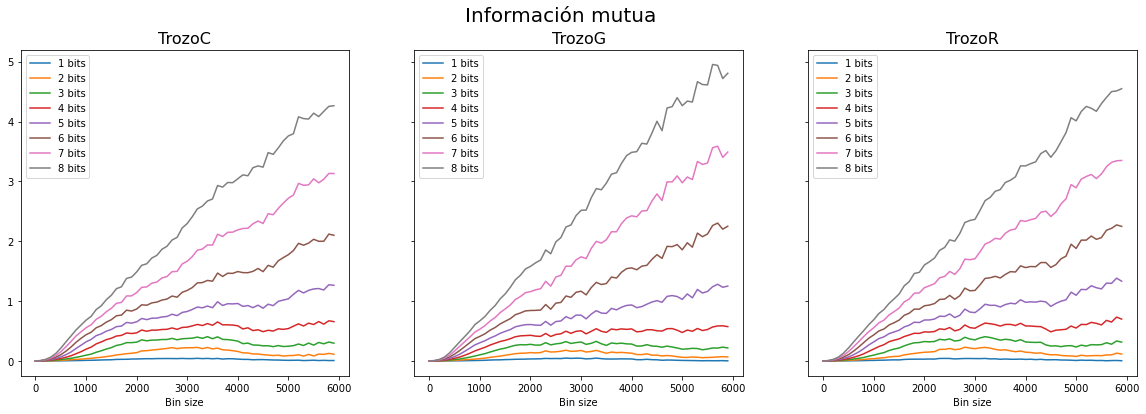

In [56]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

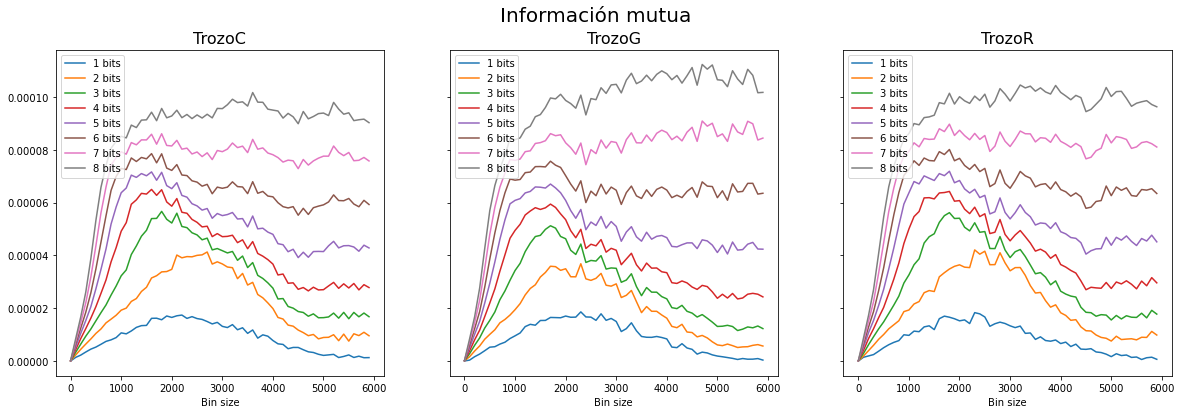

In [57]:
plot_mutual_information_by_bin_size(information_C, information_G, information_R, word_size, bin_size)

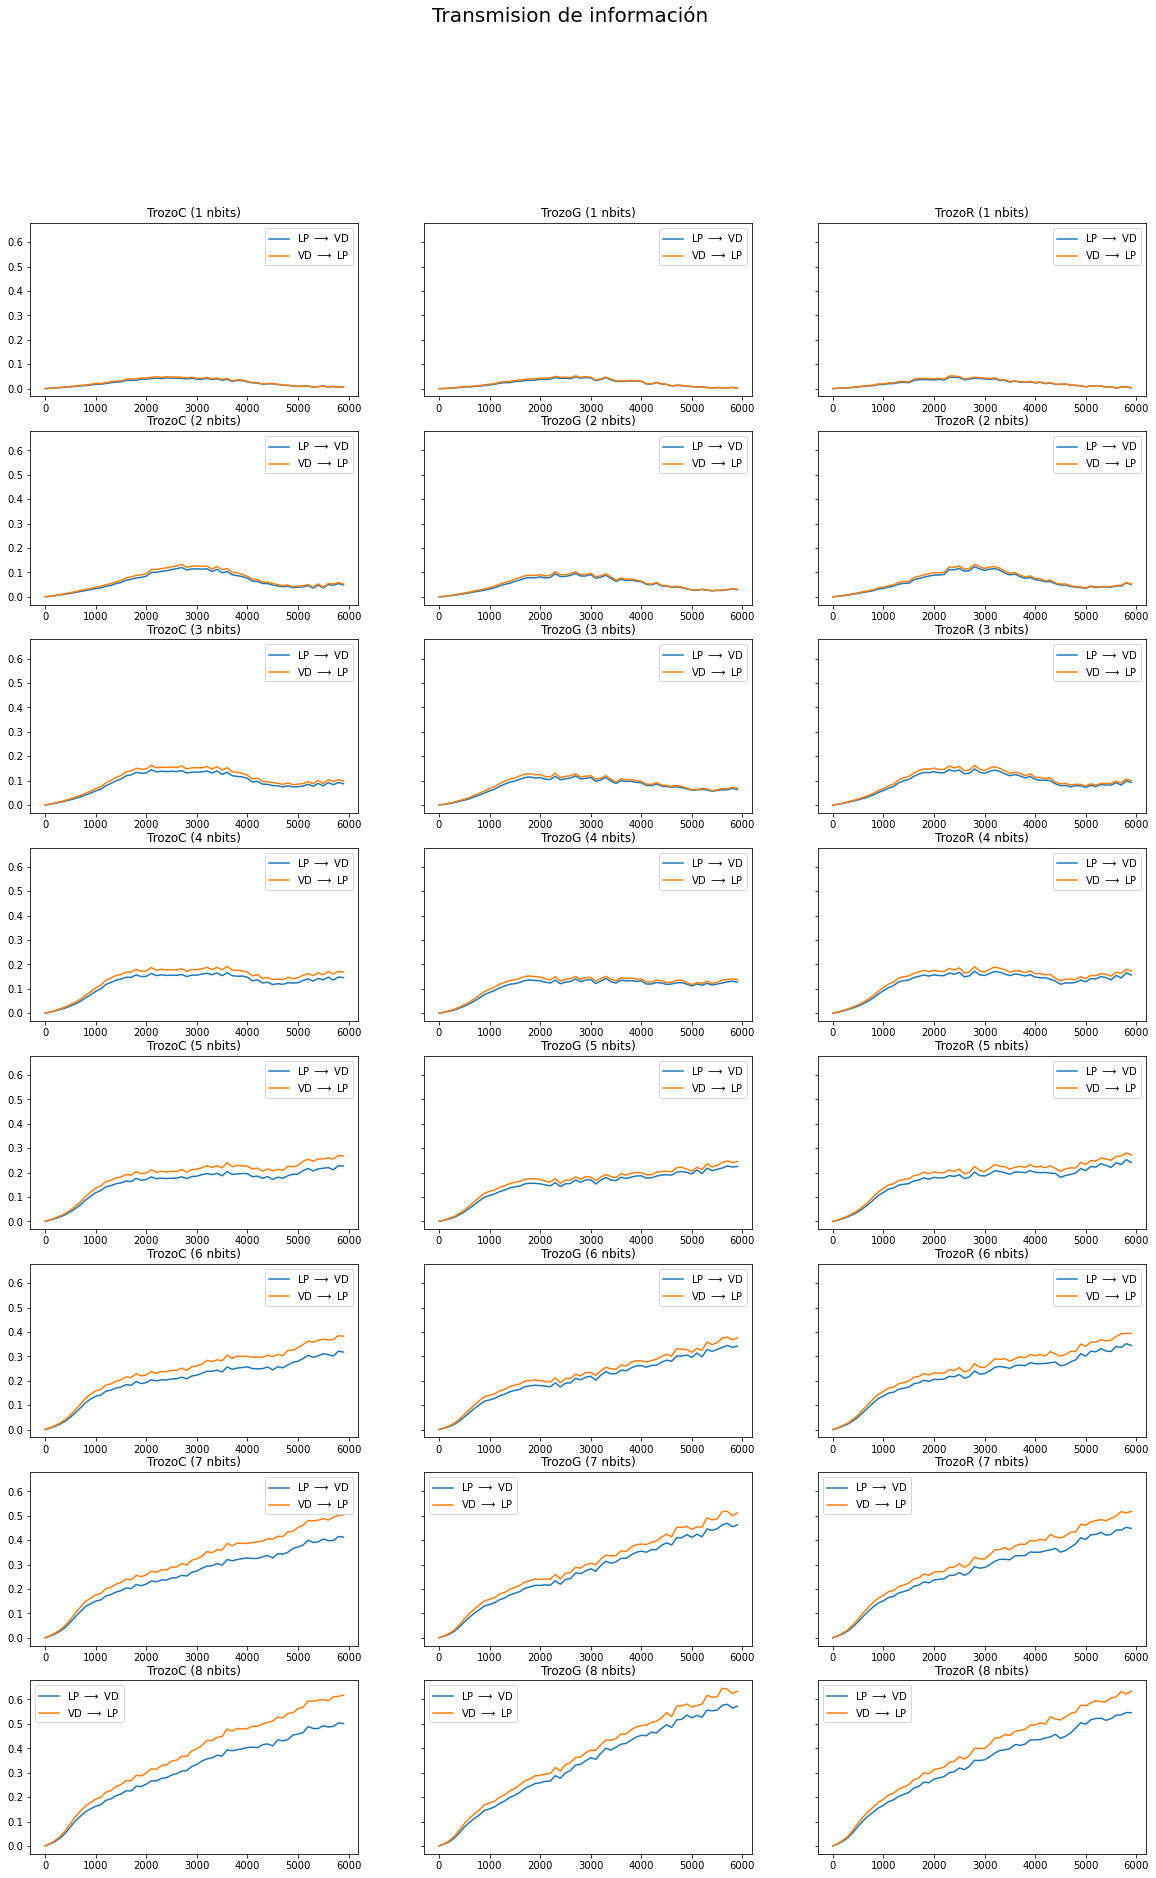

In [58]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

Se puede observar un resultado muy parecido al obtenido con palabras fijas.

### Conclusiones